# Benchmarking feature selection algorithms in the molecular property prediction space


In [29]:
# General use 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import shap
import joblib
import scipy
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import time

# Datasets
from tdc.single_pred import ADME, Tox

#Models - Regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

#Models - Classification
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Standardizing
from molvs import standardize_smiles

# RDkit
from rdkit import Chem
from rdkit import RDLogger
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

#Feature selection
from mrmr import mrmr_classif
from sklearn.feature_selection import SelectKBest
from skrebate import ReliefF
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

#
import warnings
warnings.filterwarnings('ignore')

In [30]:
benchmark = []

## Lipophilicity

Lipophilicity measures the ability of a drug to dissolve in a lipid (e.g. fats, oils) environment. High lipophilicity often leads to high rate of metabolism, poor solubility, high turn-over, and low absorption

In [31]:
data = ADME(name = 'Lipophilicity_AstraZeneca')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_LIPO = data.get_split()

Found local copy...
Loading...
Done!


In [32]:
def data_overview(df, split):
    print('Total number of molecules:',len(df))
    print('Train set: %d - %0.1f%%' %(len(split['train']), len(split['train'])/len(df)*100))
    print('Validation set: %d - %0.1f%%' %(len(split['valid']), len(split['valid'])/len(df)*100))
    print('Test set: %d - %0.1f%%' %(len(split['test']), len(split['test'])/len(df)*100))
    display(split['train'].head())

In [33]:
data_overview(df, split_LIPO)

Total number of molecules: 4200
Train set: 2940 - 70.0%
Validation set: 420 - 10.0%
Test set: 840 - 20.0%


,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51


### Data Cleaning

In [34]:
# Remove fragments of compounds that may contain them
frag_compounds = [comp for comp in df['Drug'] if len(comp.split('.')) > 1]
for ind, c in enumerate(frag_compounds):
    df.loc[df.Drug == frag_compounds[ind], 'Drug'] = frag_compounds[ind].split('.')[0]

print('Number of compounds modified: {}'.format(len(frag_compounds)))

Number of compounds modified: 1


In [35]:
def remove_ha_duplicates(df):
    og_shape = df.shape
    heavy_atoms = pd.Series([Chem.MolFromSmiles(smi).GetNumHeavyAtoms() for smi in df['Drug']])
    # DF now only contains compounds with 5 or more heavy atoms
    df = df[heavy_atoms >= 5]
    # Duplicates removal from DF
    df.drop(df[df['Drug'].duplicated()].index, inplace = True)
    
    print('Duplicated compounds and with less than 5 heavy atoms have been removed.')
    print('New number of compounds: %d (%d)' %(df.shape[0], (df.shape[0] - og_shape[0])))
    return df

In [36]:
# Duplicates and compounds with less than 5 heavy atoms removal
df = remove_ha_duplicates(df)

Duplicated compounds and with less than 5 heavy atoms have been removed.
New number of compounds: 4200 (0)


### Descriptors
Contain numerical information regarding the molecule 

In [37]:
descList = [i for i,j in Descriptors.descList]
#Molecular descriptor calculator
calculator = MolecularDescriptorCalculator(descList)
print('Calculator initialized. Total number of descriptors:', len(descList))

Calculator initialized. Total number of descriptors: 208


In [38]:
# Standardize the molecules 
df['Drug'] = [standardize_smiles(smi) for smi in df['Drug']]

# Generate a list of lists where each row corresponds to a molecule and each column to a descriptor (transpose step required)
c = [calculator.CalcDescriptors(Chem.MolFromSmiles(smi)) for smi in df['Drug']]

# Convert it into a numpy array and transpose it so the columns represent the descriptors
c = np.asarray(c).transpose()

# Append all the descriptors to the DF
for i, descriptor in enumerate(descList):
    df[descriptor] = c[i]
    
#We move the target (lipophilicity value) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

print('Actual shape of the Dataframe:', df.shape)

Actual shape of the Dataframe: (4200, 211)


In [39]:
df.head()

,Drug_ID,Drug,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,5.976320,0.790958,5.976320,0.790958,0.728444,340.858,319.690,340.145474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,13.847757,-4.060285,13.847757,0.083663,0.545587,494.591,468.383,494.118143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,12.294248,-0.447454,12.294248,0.262241,0.807761,321.829,305.701,321.059027,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.69
3,CHEMBL234951,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,12.966133,-1.063518,12.966133,0.046181,0.506650,419.890,401.746,419.070655,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.37
4,CHEMBL565079,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,12.834652,-0.795707,12.834652,0.112199,0.747686,381.480,354.264,381.216475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.10


### Fingerprints
Allows us to find patterns in molecule structures.

In [40]:
# FP_data = (num_mols x numVectorBits)
def generate_fingerprints(mol, fp_type="ECFP", r = 2, bits =1024):
    fp_arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol,r,bits),fp_arr)    
    return fp_arr

In [41]:
# Generate fingerprints dataset and transform into a dataframe
fps = pd.DataFrame([generate_fingerprints(Chem.MolFromSmiles(mol)) for mol in df['Drug']],columns = np.arange(1,1025))

In [42]:
fps.head()

,1,2,3,4,5,6,7,8,9,10,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Generate splits, remove NaNs, and normalization


In [43]:
# Remove molecules that contain many zero-value/nan features
def remove_nans(X_train, X_val, X_test, y_train, y_val, y_test, X_train_fps, X_val_fps, X_train_all, X_val_all, X_test_all):
    for ind, dset in enumerate([X_train, X_val, X_test]):
        nan_mols = dset.isnull().any(axis=1)
        if len(dset[nan_mols].index) !=0 :
            # Check rows where NaN values are located 
            nan_rows = dset[nan_mols].index
            # Remove NaNs in dataset
            dset.drop(index = nan_rows, inplace = True)
            if ind == 0:
                y_train.drop(index = nan_rows, inplace = True)
                X_train_fps.drop(index = nan_rows, inplace = True)
                X_train_all.drop(index = nan_rows, inplace = True)
                print('Removed the following rows in the train set:',nan_rows)

            elif ind == 1:
                X_val_fps.drop(index = nan_rows, inplace = True)
                X_val_all.drop(index = nan_rows, inplace = True)
                y_val.drop(index = nan_rows, inplace = True)
                print('Removed the following rows in the val set:',nan_rows)

            else:
                y_test.drop(index = nan_rows, inplace = True)
                print('Removed the following rows in the test set:',nan_rows)
        
    return X_train, X_train_fps, X_train_all, y_train, X_val, X_val_fps, X_val_all, y_val, X_test, X_test_all, y_test

In [44]:
def train_val_test_split(df, split, fps):
    
    # Training
    X_train = df[df.columns[3:-1]][:len(split['train'])]
    y_train = df['Y'][:len(split['train'])]
    #Same with fingerprints (Since Y is the same, we just need to care of X)
    X_train_fps = fps[fps.columns[:]][:len(split['train'])]
    ## descriptors + fingerprints
    X_train_all = pd.concat([X_train,X_train_fps], axis= 1, join= 'inner')
    
    # Validation
    X_val = df[df.columns[3:-1]][len(split['train']):(len(split['valid'])+len(split['train']))]
    y_val = df['Y'][len(split['train']):(len(split['valid'])+len(split['train']))]
    #Same with fingerprints (Since Y is the same, we just need to care of X)
    X_val_fps = fps[fps.columns[:]][len(split['train']):(len(split['valid'])+len(split['train']))]
    ## descriptors + fingerprints
    X_val = X_val.set_index(np.arange(2940,3360))
    X_val_all = pd.concat([X_val,X_val_fps], axis= 1, join= 'inner')
    # Test
    X_test = df[df.columns[3:-1]][(len(split['valid'])+len(split['train'])):len(df)]
    y_test = df['Y'][(len(split['valid'])+len(split['train'])):len(df)]
    #Same with fingerprints (Since Y is the same, we just need to care of X)
    X_test_fps = fps[fps.columns[:]][(len(split['valid'])+len(split['train'])):len(df)]
    ## descriptors + fingerprints
    X_test_all=pd.concat([X_test,X_test_fps], axis= 1, join= 'inner')
    
    print('Data has been split')
    
    return X_train, X_train_fps, X_train_all, y_train, X_val, X_val_fps, X_val_all, y_val, X_test, X_test_fps, X_test_all, y_test

#### Train, validation, and test sets for both Descriptors and fingerprints

In [45]:
X_train, X_train_fps, X_train_all, y_train, X_val, X_val_fps, X_val_all, y_val, X_test, X_test_fps, X_test_all, y_test = train_val_test_split(df, split_LIPO, fps)

Data has been split


#### Remove NaNs values

In [46]:
X_train, X_train_fps, X_train_all, y_train, X_val, X_val_fps, X_val_all, y_val, X_test, X_test_all, y_test = remove_nans(X_train, X_val, X_test, y_train, y_val, y_test, X_train_fps, X_val_fps, X_train_all, X_val_all, X_test_all)

Removed the following rows in the train set: Int64Index([1561], dtype='int64')


#### Data normalization required in linear models

In [47]:
def normalize_data(X_train, X_val, X_test):
    scaler = StandardScaler()
    
    # convert in into DF after standardizing 
    X_train_norm = scaler.fit_transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
   #X_train_all_norm = scaler.fit_transform(X_train_all)
   # X_train_all_norm = pd.DataFrame(X_train_all_norm, columns = X_train_all.columns)
    
    X_val_norm = scaler.transform(X_val)
    X_val_norm = pd.DataFrame(X_val_norm, columns = X_val.columns)
   # X_val_all = X_val_all.set_index(np.arange(2940,3360))
   # X_val_all_norm = scaler.transform(X_val_all)
   # X_val_all_norm = pd.DataFrame(X_val_all_norm, columns = X_val_all.columns)
    
    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
    #X_test_all_norm = scaler.transform(X_test_all)
   # X_test_all_norm = pd.DataFrame(X_test_all_norm, columns = X_test_all.columns)
    
    print('Data is now normalized.')
    return X_train_norm, X_val_norm, X_test_norm

In [48]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


In [49]:
X_train_all_norm, X_val_all_norm, X_test_all_norm = normalize_data(X_train_all, X_val_all, X_test_all)

Data is now normalized.


## Data visualization

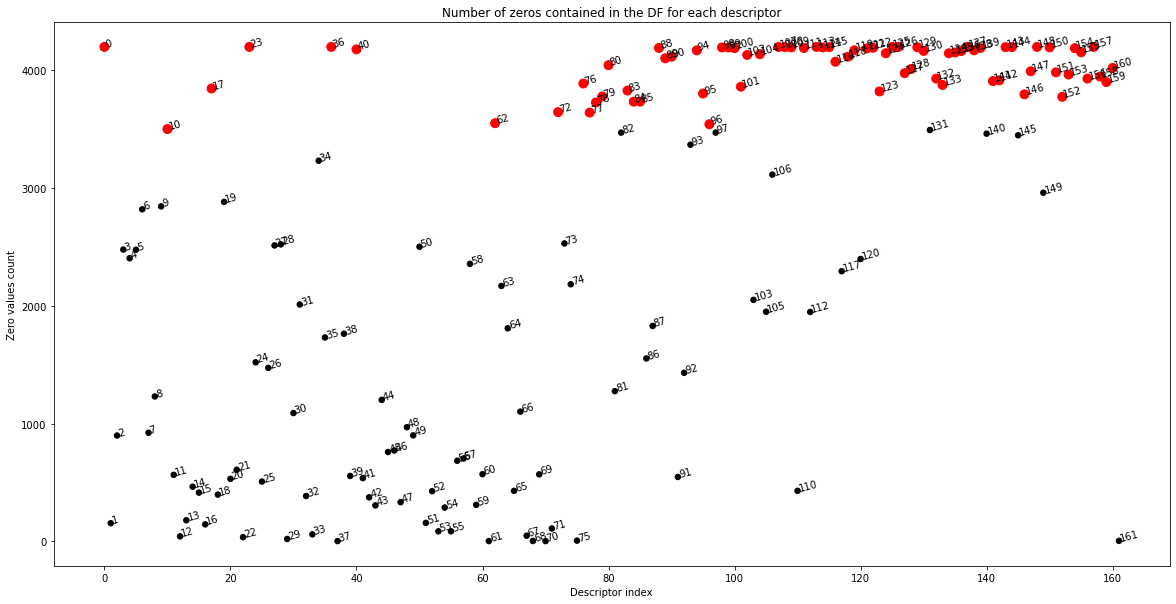

In [16]:
#We now count the number of Zeros in each column

threshold = 3500
#Columns that contain zero values
desc_name = df.columns[(df == 0).sum(axis=0) > 0]
desc_count = (df[df.columns[(df == 0).sum(axis=0) > 0]] == 0).sum(axis=0)

color = ['red' if i > threshold else 'black' for i in desc_count]
size = [80 if i > threshold else 30 for i in desc_count]

# Scatter plot
fig, ax = plt.subplots();
ax.scatter(np.arange(len(desc_name)), desc_count, c=color, s=size)
plt.title('Number of zeros contained in the DF for each descriptor')
plt.xlabel('Descriptor index')
plt.ylabel('Zero values count')
fig.set_size_inches(20, 10);

for i in np.arange(len(desc_name)):
    ax.annotate(i, (i, desc_count[i]), rotation=15)
    
plt.show()

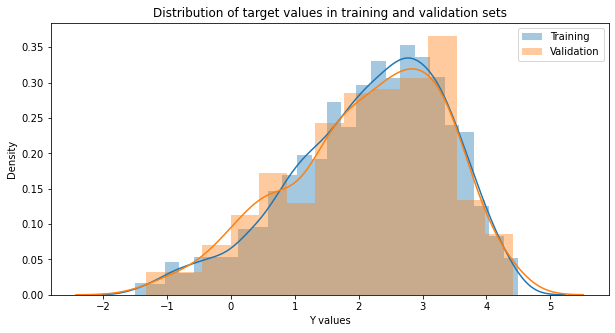

In [17]:
# Visualize data distribution in traning and validation datasets

fig, ax = plt.subplots(figsize=(10,5))

for ind, a in enumerate([y_train, y_val]):
    if ind == 0:
        sns.distplot(a, ax=ax, label = 'Training')
    else:
        sns.distplot(a, ax=ax, label = 'Validation')

plt.xlabel('Y values')
plt.title('Distribution of target values in training and validation sets') 
plt.legend(loc = 'best')
plt.show()

## Building our baseline models

In order to get some initial results, we will now construct a few baseline models where all the features are included without any preprocessing.

We now compare the metrics obtained for each of the following models:

- Random forest regressor (**RFR**)
- Decision tree regressor (**DTR**)
- Support vector machine (**SVM**)
- Multi-layer Perceptron regressor (**MLP**)
- XG Boost regressor (**XGB)

In [50]:
# Compute regression metrics 
def get_metrics(model_name, y_true, y_pred, c, train_time, pred_time, mode = 0):
    
    # Compute metrics 
    if c == False:
        var1 = metrics.r2_score(y_true, y_pred)
        var2 = metrics.mean_absolute_error(y_true, y_pred)
        var3 = metrics.mean_squared_error(y_true, y_pred)
        
        print(model_name,'| Traing Duration: %0.2f, Prediction Duration: %0.2f | R2: %0.2f, MAE: %0.2f, MSE: %0.2f' %(train_time, pred_time, var1, var2, var3))
        
        # Mode to 1 displays r-squared plots
        if mode == 1: 
            plt.figure(figsize=(10, 5), dpi = 95)

            plt.scatter(y_true, y_pred, color='salmon', s=5)
            plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_pred, 1))(np.unique(y_true)), color='black')

            plt.text(0, 3.5,'R-squared = %0.2f' % var1)
            plt.xlabel('Actual values')
            plt.ylabel('Predicted Values')
            plt.title('Prediction results using {}'.format(model_name))
            plt.show()
        
        return  var1, var2, var3
        
    else:
        var1 = metrics.matthews_corrcoef(y_true, y_pred)
        var2 = metrics.roc_auc_score(y_true, y_pred)
        var3 = metrics.precision_score(y_true, y_pred)
        var4 = metrics.recall_score(y_true, y_pred)
        var5 = metrics.accuracy_score(y_true, y_pred)
        
        print(model_name,'| Traing Duration: %0.2f, Prediction Duration: %0.2f | MCC: %0.2f, AUC: %0.2f, Accuracy: %0.2f, Precision: %0.2f, Recall: %0.2f' 
              %(train_time, pred_time, var1, var2, var3, var4, var5))
        
    return var1, var2, var3, var4, var5

In [51]:
def models_comparison(x_train, y_train, x_val, y_val, c, plot = True, fps = False 
                          , x_train_norm = 0, x_val_norm = 0):
    np.random.seed(10)
    n_models = ['LR', 'RFR', 'DTR', 'SVR', 'MLPR', 'MLPC', 'SVC', 'RFC', 'DTC']
    models = {'Regression': 
              {'Linear': {'LR': LinearRegression(), 'SVR': SVR(C=1), 
                          'MLPR': MLPRegressor(hidden_layer_sizes=(128,64,32), max_iter=500)},
               'Non-linear':{'RFR': RandomForestRegressor(), 'DTR': DecisionTreeRegressor(), 'SVR':SVR()}},
                  
              'Classification': 
              {'Linear': {'SVC': SVC(), 
                          'MLPC': MLPClassifier(hidden_layer_sizes=(128,64,32), max_iter=500)},
               'Non-linear':{'RFC': RandomForestClassifier(), 'DTC': DecisionTreeClassifier()}}
             }
             

    names = []
    results = []
    duration =[]
    
    for name in n_models:
        clf=0
        #REGRESSION
        if name in models['Regression']['Linear'].keys() and c == False  :
            if fps == False:
                start = time.time()
                clf = models['Regression']['Linear'][name].fit(x_train_norm, y_train)
                end = time.time()
                train_time= end - start
                t0 = time.time()
                y_pred = clf.predict(x_val_norm)
                t1 = time.time()
                pred_time = t1-t0
            else:
                start = time.time()
                clf = models['Regression']['Linear'][name].fit(x_train, y_train)
                end = time.time()
                train_time= end - start
                t0 = time.time()
                y_pred = clf.predict(x_val)
                t1 = time.time()
                pred_time = t1-t0
            duration.append([train_time,pred_time])
            names.append(name)
            r2, mae, mse = get_metrics(name, y_val, y_pred, c, train_time, pred_time)
            results.append([ r2, mae, mse])
            
        elif name in models['Regression']['Non-linear'].keys() and c == False  :
            start = time.time()
            clf = models['Regression']['Non-linear'][name].fit(x_train, y_train)
            end = time.time()
            train_time= end - start
            t0 = time.time()
            y_pred = clf.predict(x_val)
            t1 = time.time()
            pred_time = t1-t0

            duration.append([train_time,pred_time])
            names.append(name)
            r2, mae, mse = get_metrics(name, y_val, y_pred, c, train_time, pred_time)
            results.append([r2, mae, mse])
        
        
        #CLASSIFICATION
        elif name in models['Classification']['Linear'].keys() and c == True:
            start = time.time()
            clf = models['Classification']['Linear'][name].fit(x_train_norm, y_train)
            end = time.time()
            train_time= end - start
            y_pred = clf.predict(x_val_norm)
            t1 = time.time()
            pred_time = t1-t0
            duration.append([train_time,pred_time])
            names.append(name)
            mcc, auc, acc, pre, rec = get_metrics(name, y_val, y_pred, c, train_time, pred_time)
            results.append([mcc, auc, acc, pre, rec])
            
        elif name in models['Classification']['Non-linear'].keys() and c == True :
            start = time.time()
            clf = models['Classification']['Non-linear'][name].fit(x_train, y_train)  
            end = time.time()
            train_time= end - start
            y_pred = clf.predict(x_val)
            t1 = time.time()
            pred_time = t1-t0
            duration.append([train_time,pred_time])
            names.append(name)
            mcc, auc, acc, pre, rec= get_metrics(name, y_val, y_pred, c, train_time, pred_time)
            results.append([mcc, auc, acc, pre, rec])
        
        else:
            pass
        
    # We plot the metrics obtained for each model
    if plot == True:
        plot_comparison(names, results, c)
        plot_time(names, duration, c)
    return names, results

In [52]:
def plot_comparison(names, met, c):
    sns.set(font_scale = 1)
    # set width of bar
    barWidth = 0.15
    plt.figure(figsize=(15, 6), dpi = 95)

    # set height of bar
    var1 = [i[0] for i in met]
    var2 = [i[1] for i in met]
    var3 = [i[2] for i in met]
    if c == True:
        var4 = [i[3] for i in met]
        var5 = [i[4] for i in met]

    # Set position of bar on X axis
    br1 = np.arange(len(var1))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    br5 = [x + barWidth for x in br4]

    # Make the plot
    if c == False:
        plt.bar(br1, var1, color ='r', width = barWidth,
                edgecolor ='grey', label ='R2')
        plt.bar(br2, var2, color ='g', width = barWidth,
                edgecolor ='grey', label ='MAE')
        plt.bar(br3, var3, color ='b', width = barWidth,
                edgecolor ='grey', label ='MSE')
    
    # Add 2 more bars 
    else :
        plt.bar(br1, var1, color ='r', width = barWidth,
                edgecolor ='grey', label ='MCC')
        plt.bar(br2, var2, color ='g', width = barWidth,
                edgecolor ='grey', label ='AUC')
        plt.bar(br3, var3, color ='b', width = barWidth,
                edgecolor ='grey', label ='ACC')
        plt.bar(br4, var4, color ='yellow', width = barWidth,
            edgecolor ='grey', label ='PRE')
        plt.bar(br5, var5, color ='purple', width = barWidth,
            edgecolor ='grey', label ='REC')
    
    # Adding Xticks
    plt.xlabel('Models', fontweight ='bold', fontsize = 15)
    plt.ylabel('Metrics', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(var1))],
            [name for name in names])
    plt.legend()
    plt.title('Metrics obtained for each model')
    
    plt.show()

In [53]:
def plot_time(names, t, c):
    sns.set(font_scale = 1)
    # set width of bar
    barWidth = 0.15
    plt.figure(figsize=(15, 6), dpi = 95)

    # set height of bar
    var1 = [i[0] for i in t]
    var2 = [i[1] for i in t]
  


    # Set position of bar on X axis
    br1 = np.arange(len(var1))
    br2 = [x + barWidth for x in br1]


    # Make the plot

    plt.bar(br1, var1, color ='cyan', width = barWidth,
                edgecolor ='grey', label ='Training Duration')
    plt.bar(br2, var2, color ='green', width = barWidth,
                edgecolor ='grey', label ='Prediction Duration')

    

    
    # Adding Xticks
    plt.xlabel('Models', fontweight ='bold', fontsize = 15)
    plt.ylabel('Metrics', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(var1))],
            [name for name in names])
    plt.legend()
    plt.title('Metrics obtained for each model')
    
    plt.show()

In [55]:
def add_to_benchmark(benchmark, models, results, manual = False):
    temp = [r2[0] for r2 in results]
    # (name of model, r2 score, ID). ID is previousID +1
    if len(benchmark) == 0:
        benchmark.append((models[np.argmax(temp)], np.max(temp), 0))
    else:
        benchmark.append((models[np.argmax(temp)], np.max(temp), benchmark[len(benchmark)-1][2]+1))
    
    
    return benchmark

#### Descriptors

LR | Traing Duration: 1.17, Prediction Duration: 0.00 | R2: 0.60, MAE: 0.59, MSE: 0.60
RFR | Traing Duration: 20.59, Prediction Duration: 0.02 | R2: 0.64, MAE: 0.55, MSE: 0.53
DTR | Traing Duration: 0.34, Prediction Duration: 0.00 | R2: 0.31, MAE: 0.76, MSE: 1.03
SVR | Traing Duration: 2.51, Prediction Duration: 0.33 | R2: 0.69, MAE: 0.50, MSE: 0.46
MLPR | Traing Duration: 4.92, Prediction Duration: 0.00 | R2: 0.65, MAE: 0.51, MSE: 0.52


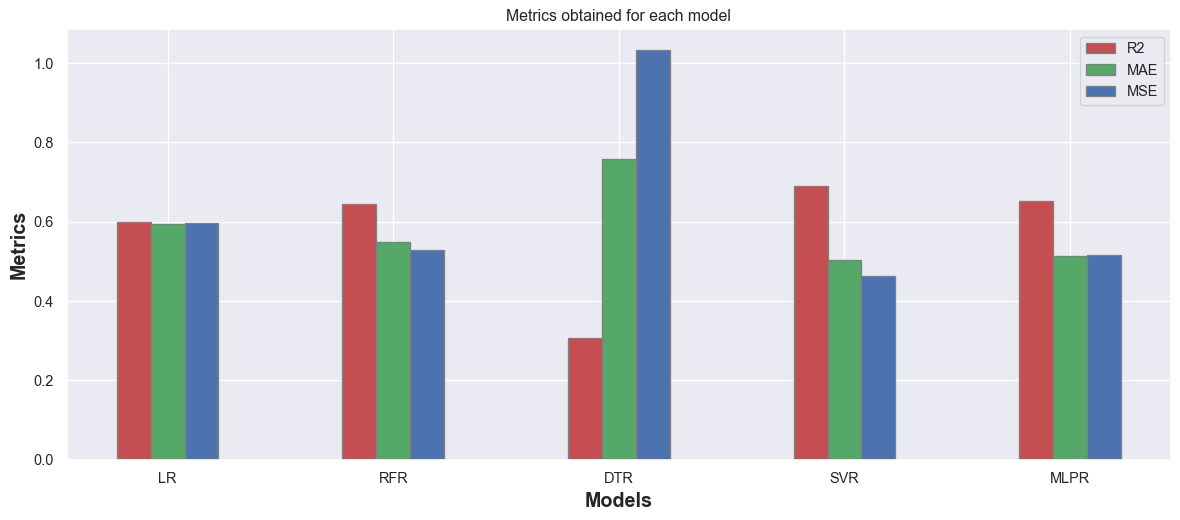

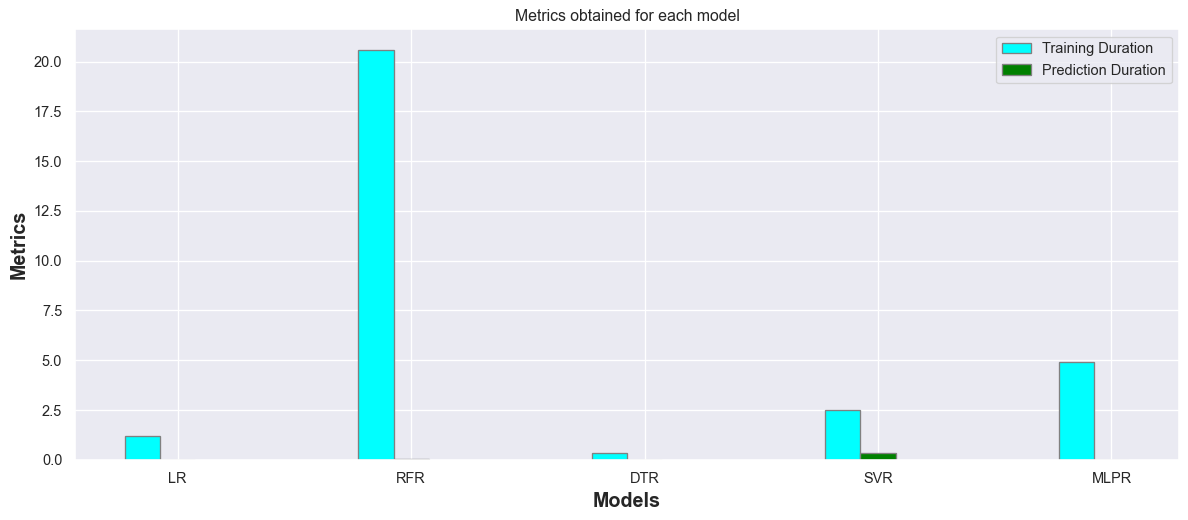

In [54]:
models, results = models_comparison(X_train, y_train, X_val, y_val, False, True, False, X_train_norm, X_val_norm)

In [214]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, models, results)

#### Fingerprints

LR | Traing Duration: 0.59, Prediction Duration: 0.00 | R2: 0.38, MAE: 0.72, MSE: 0.92
RFR | Traing Duration: 43.01, Prediction Duration: 0.02 | R2: 0.50, MAE: 0.66, MSE: 0.74
DTR | Traing Duration: 0.66, Prediction Duration: 0.00 | R2: 0.05, MAE: 0.86, MSE: 1.42
SVR | Traing Duration: 11.12, Prediction Duration: 1.51 | R2: 0.56, MAE: 0.63, MSE: 0.66
MLPR | Traing Duration: 10.33, Prediction Duration: 0.01 | R2: 0.54, MAE: 0.61, MSE: 0.69


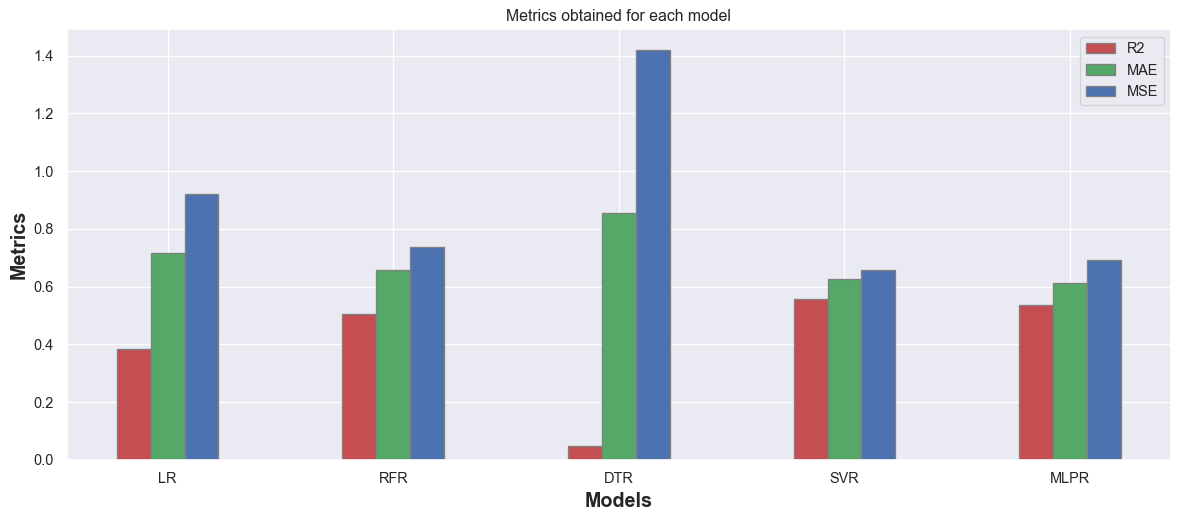

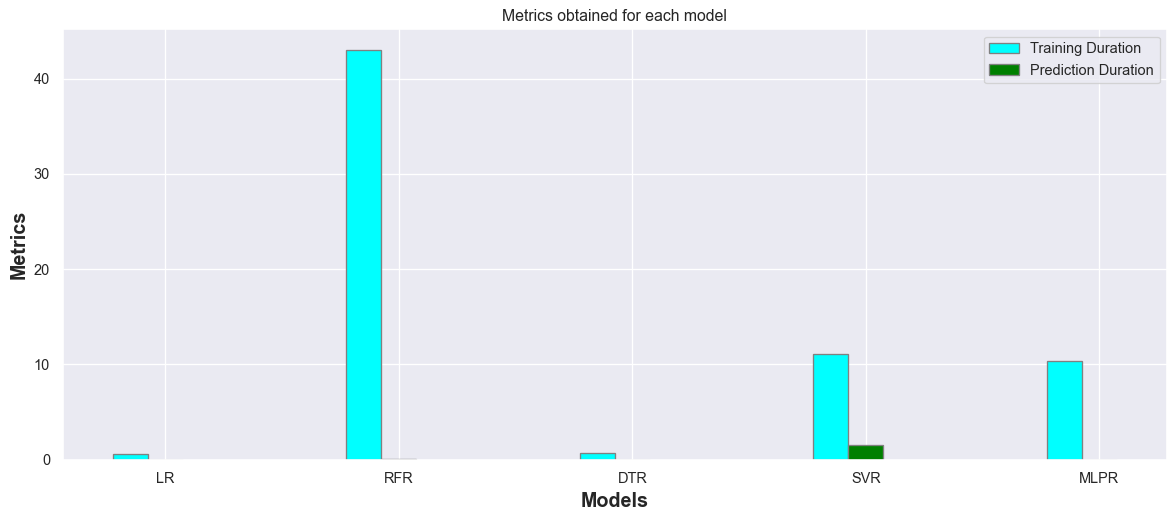

In [56]:
models, results = models_comparison(X_train_fps, y_train, X_val_fps, y_val, False, True, True, X_train_fps, X_val_fps)

### Descriptors + Fingerprints

LR | Traing Duration: 0.94, Prediction Duration: 0.00 | R2: 0.53, MAE: 0.61, MSE: 0.71
RFR | Traing Duration: 56.59, Prediction Duration: 0.02 | R2: 0.66, MAE: 0.54, MSE: 0.51
DTR | Traing Duration: 0.88, Prediction Duration: 0.02 | R2: 0.29, MAE: 0.74, MSE: 1.05
SVR | Traing Duration: 12.88, Prediction Duration: 1.84 | R2: 0.65, MAE: 0.55, MSE: 0.52
MLPR | Traing Duration: 6.42, Prediction Duration: 0.01 | R2: 0.57, MAE: 0.61, MSE: 0.64


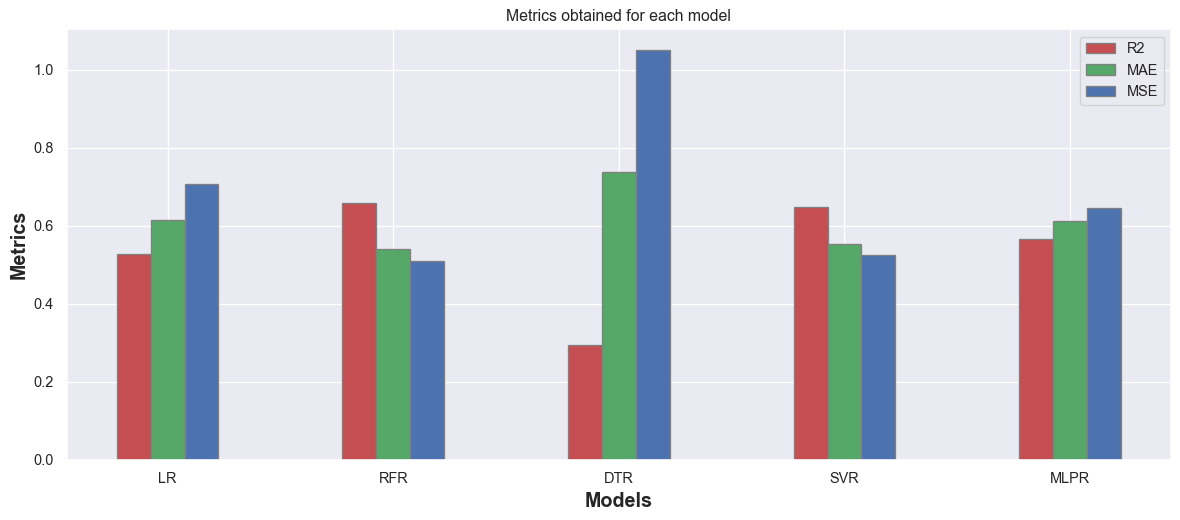

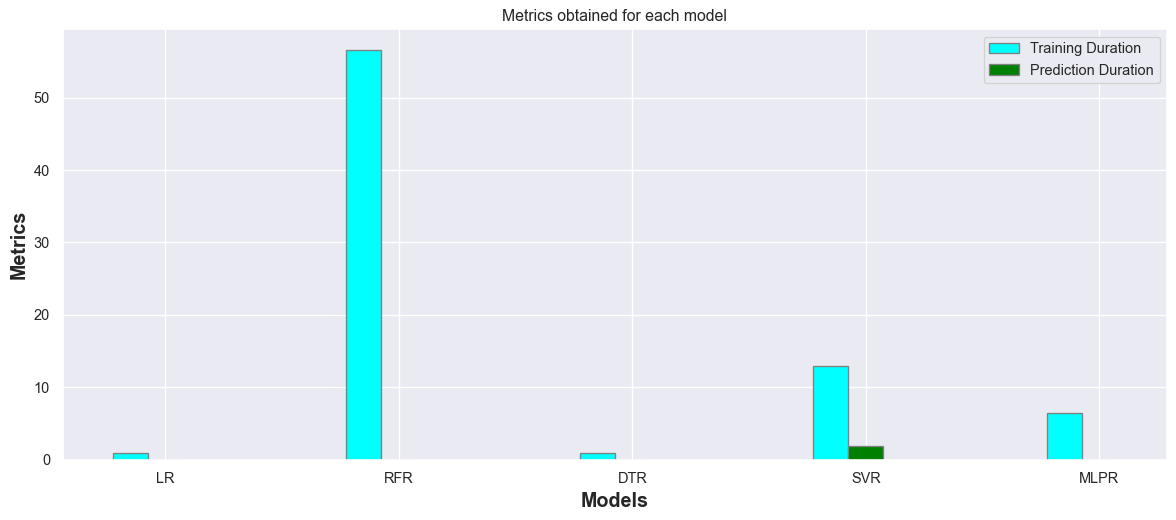

In [57]:
models, results = models_comparison(X_train_all, y_train, X_val_all, y_val, False, True, False, X_train_all_norm, X_val_all_norm)

## Improving the model 

### Improving the model: Feature Selection - MRMR

In [21]:
models, results, num_sel_feat, features = fs_mrmr(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.71it/s]


RFR | R2: -0.055, MAE: 0.956, MSE: 1.571
DTR | R2: -0.387, MAE: 1.077, MSE: 2.064
SVR | R2: -0.035, MAE: 0.994, MSE: 1.541
MLPR | R2: -0.006, MAE: 0.994, MSE: 1.497
XGBR | R2: 0.105, MAE: 0.916, MSE: 1.333


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.02it/s]


RFR | R2: -0.049, MAE: 0.952, MSE: 1.562
DTR | R2: -0.393, MAE: 1.081, MSE: 2.073
SVR | R2: -0.032, MAE: 0.991, MSE: 1.536
MLPR | R2: -0.009, MAE: 0.999, MSE: 1.502
XGBR | R2: 0.080, MAE: 0.931, MSE: 1.370


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.79it/s]


RFR | R2: 0.119, MAE: 0.867, MSE: 1.312
DTR | R2: -0.184, MAE: 0.994, MSE: 1.762
SVR | R2: 0.090, MAE: 0.930, MSE: 1.355
MLPR | R2: 0.086, MAE: 0.946, MSE: 1.360
XGBR | R2: 0.223, MAE: 0.844, MSE: 1.157


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.49it/s]


RFR | R2: 0.133, MAE: 0.862, MSE: 1.290
DTR | R2: -0.222, MAE: 0.995, MSE: 1.819
SVR | R2: 0.090, MAE: 0.929, MSE: 1.355
MLPR | R2: 0.104, MAE: 0.941, MSE: 1.333
XGBR | R2: 0.246, MAE: 0.833, MSE: 1.123


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.63it/s]


RFR | R2: 0.404, MAE: 0.722, MSE: 0.887
DTR | R2: 0.030, MAE: 0.881, MSE: 1.444
SVR | R2: 0.362, MAE: 0.765, MSE: 0.950
MLPR | R2: 0.386, MAE: 0.754, MSE: 0.914
XGBR | R2: 0.422, MAE: 0.727, MSE: 0.860


100%|███████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 15.47it/s]


RFR | R2: 0.466, MAE: 0.687, MSE: 0.794
DTR | R2: 0.159, MAE: 0.808, MSE: 1.252
SVR | R2: 0.381, MAE: 0.741, MSE: 0.922
MLPR | R2: 0.400, MAE: 0.731, MSE: 0.892
XGBR | R2: 0.446, MAE: 0.716, MSE: 0.825


100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.33it/s]


RFR | R2: 0.473, MAE: 0.687, MSE: 0.784
DTR | R2: 0.114, MAE: 0.850, MSE: 1.319
SVR | R2: 0.403, MAE: 0.731, MSE: 0.889
MLPR | R2: 0.401, MAE: 0.729, MSE: 0.891
XGBR | R2: 0.489, MAE: 0.679, MSE: 0.761


100%|███████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 15.62it/s]


RFR | R2: 0.485, MAE: 0.672, MSE: 0.766
DTR | R2: 0.152, MAE: 0.838, MSE: 1.262
SVR | R2: 0.421, MAE: 0.715, MSE: 0.862
MLPR | R2: 0.444, MAE: 0.705, MSE: 0.828
XGBR | R2: 0.472, MAE: 0.691, MSE: 0.786


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.86it/s]


RFR | R2: 0.468, MAE: 0.677, MSE: 0.792
DTR | R2: 0.013, MAE: 0.898, MSE: 1.469
SVR | R2: 0.440, MAE: 0.697, MSE: 0.834
MLPR | R2: 0.402, MAE: 0.711, MSE: 0.890
XGBR | R2: 0.492, MAE: 0.674, MSE: 0.756


100%|███████████████████████████████████████████████████████████████████████████████| 55/55 [00:03<00:00, 16.01it/s]


RFR | R2: 0.521, MAE: 0.645, MSE: 0.713
DTR | R2: 0.061, MAE: 0.879, MSE: 1.398
SVR | R2: 0.456, MAE: 0.672, MSE: 0.810
MLPR | R2: 0.372, MAE: 0.701, MSE: 0.935
XGBR | R2: 0.520, MAE: 0.653, MSE: 0.715


100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.89it/s]


RFR | R2: 0.551, MAE: 0.623, MSE: 0.668
DTR | R2: 0.129, MAE: 0.830, MSE: 1.296
SVR | R2: 0.490, MAE: 0.645, MSE: 0.760
MLPR | R2: 0.398, MAE: 0.698, MSE: 0.896
XGBR | R2: 0.579, MAE: 0.602, MSE: 0.626


100%|███████████████████████████████████████████████████████████████████████████████| 65/65 [00:04<00:00, 16.05it/s]


RFR | R2: 0.559, MAE: 0.618, MSE: 0.656
DTR | R2: 0.199, MAE: 0.799, MSE: 1.193
SVR | R2: 0.509, MAE: 0.633, MSE: 0.731
MLPR | R2: 0.438, MAE: 0.675, MSE: 0.837
XGBR | R2: 0.596, MAE: 0.592, MSE: 0.601


100%|███████████████████████████████████████████████████████████████████████████████| 70/70 [00:04<00:00, 15.95it/s]


RFR | R2: 0.576, MAE: 0.606, MSE: 0.631
DTR | R2: 0.232, MAE: 0.789, MSE: 1.144
SVR | R2: 0.566, MAE: 0.600, MSE: 0.647
MLPR | R2: 0.463, MAE: 0.642, MSE: 0.800
XGBR | R2: 0.610, MAE: 0.573, MSE: 0.581


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 16.30it/s]


RFR | R2: 0.601, MAE: 0.585, MSE: 0.594
DTR | R2: 0.212, MAE: 0.799, MSE: 1.173
SVR | R2: 0.585, MAE: 0.584, MSE: 0.618
MLPR | R2: 0.580, MAE: 0.567, MSE: 0.625
XGBR | R2: 0.635, MAE: 0.554, MSE: 0.543


100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 16.37it/s]


RFR | R2: 0.611, MAE: 0.578, MSE: 0.578
DTR | R2: 0.286, MAE: 0.772, MSE: 1.063
SVR | R2: 0.595, MAE: 0.578, MSE: 0.603
MLPR | R2: 0.537, MAE: 0.601, MSE: 0.690
XGBR | R2: 0.653, MAE: 0.544, MSE: 0.516


100%|███████████████████████████████████████████████████████████████████████████████| 85/85 [00:05<00:00, 16.47it/s]


RFR | R2: 0.614, MAE: 0.581, MSE: 0.574
DTR | R2: 0.176, MAE: 0.814, MSE: 1.226
SVR | R2: 0.611, MAE: 0.568, MSE: 0.579
MLPR | R2: 0.555, MAE: 0.589, MSE: 0.662
XGBR | R2: 0.642, MAE: 0.547, MSE: 0.534


100%|███████████████████████████████████████████████████████████████████████████████| 90/90 [00:05<00:00, 16.95it/s]


RFR | R2: 0.611, MAE: 0.576, MSE: 0.579
DTR | R2: 0.343, MAE: 0.746, MSE: 0.977
SVR | R2: 0.630, MAE: 0.555, MSE: 0.551
MLPR | R2: 0.566, MAE: 0.591, MSE: 0.646
XGBR | R2: 0.643, MAE: 0.549, MSE: 0.531


100%|███████████████████████████████████████████████████████████████████████████████| 95/95 [00:05<00:00, 16.90it/s]


RFR | R2: 0.620, MAE: 0.568, MSE: 0.565
DTR | R2: 0.302, MAE: 0.764, MSE: 1.040
SVR | R2: 0.639, MAE: 0.545, MSE: 0.537
MLPR | R2: 0.624, MAE: 0.554, MSE: 0.559
XGBR | R2: 0.640, MAE: 0.544, MSE: 0.536


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.97it/s]


RFR | R2: 0.631, MAE: 0.555, MSE: 0.549
DTR | R2: 0.258, MAE: 0.771, MSE: 1.104
SVR | R2: 0.655, MAE: 0.529, MSE: 0.514
MLPR | R2: 0.624, MAE: 0.539, MSE: 0.559
XGBR | R2: 0.656, MAE: 0.520, MSE: 0.513


100%|█████████████████████████████████████████████████████████████████████████████| 105/105 [00:06<00:00, 17.15it/s]


RFR | R2: 0.629, MAE: 0.556, MSE: 0.552
DTR | R2: 0.322, MAE: 0.752, MSE: 1.010
SVR | R2: 0.663, MAE: 0.524, MSE: 0.501
MLPR | R2: 0.619, MAE: 0.533, MSE: 0.567
XGBR | R2: 0.667, MAE: 0.521, MSE: 0.496


100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.25it/s]


RFR | R2: 0.633, MAE: 0.553, MSE: 0.547
DTR | R2: 0.159, MAE: 0.841, MSE: 1.251
SVR | R2: 0.666, MAE: 0.521, MSE: 0.497
MLPR | R2: 0.612, MAE: 0.535, MSE: 0.578
XGBR | R2: 0.635, MAE: 0.542, MSE: 0.543


100%|█████████████████████████████████████████████████████████████████████████████| 115/115 [00:06<00:00, 17.38it/s]


RFR | R2: 0.635, MAE: 0.552, MSE: 0.543
DTR | R2: 0.236, MAE: 0.791, MSE: 1.137
SVR | R2: 0.672, MAE: 0.518, MSE: 0.488
MLPR | R2: 0.547, MAE: 0.585, MSE: 0.674
XGBR | R2: 0.692, MAE: 0.501, MSE: 0.458


100%|█████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.58it/s]


RFR | R2: 0.634, MAE: 0.549, MSE: 0.545
DTR | R2: 0.222, MAE: 0.783, MSE: 1.157
SVR | R2: 0.673, MAE: 0.517, MSE: 0.486
MLPR | R2: 0.624, MAE: 0.538, MSE: 0.560
XGBR | R2: 0.654, MAE: 0.534, MSE: 0.515


100%|█████████████████████████████████████████████████████████████████████████████| 125/125 [00:06<00:00, 17.88it/s]


RFR | R2: 0.635, MAE: 0.556, MSE: 0.544
DTR | R2: 0.210, MAE: 0.805, MSE: 1.176
SVR | R2: 0.670, MAE: 0.522, MSE: 0.492
MLPR | R2: 0.614, MAE: 0.544, MSE: 0.574
XGBR | R2: 0.659, MAE: 0.536, MSE: 0.508


100%|█████████████████████████████████████████████████████████████████████████████| 130/130 [00:07<00:00, 17.98it/s]


RFR | R2: 0.630, MAE: 0.558, MSE: 0.551
DTR | R2: 0.210, MAE: 0.795, MSE: 1.176
SVR | R2: 0.670, MAE: 0.522, MSE: 0.491
MLPR | R2: 0.642, MAE: 0.538, MSE: 0.533
XGBR | R2: 0.665, MAE: 0.526, MSE: 0.498


100%|█████████████████████████████████████████████████████████████████████████████| 135/135 [00:07<00:00, 18.19it/s]


RFR | R2: 0.643, MAE: 0.550, MSE: 0.532
DTR | R2: 0.248, MAE: 0.781, MSE: 1.119
SVR | R2: 0.678, MAE: 0.515, MSE: 0.480
MLPR | R2: 0.654, MAE: 0.519, MSE: 0.514
XGBR | R2: 0.670, MAE: 0.534, MSE: 0.491


100%|█████████████████████████████████████████████████████████████████████████████| 140/140 [00:07<00:00, 18.23it/s]


RFR | R2: 0.643, MAE: 0.549, MSE: 0.531
DTR | R2: 0.223, MAE: 0.803, MSE: 1.156
SVR | R2: 0.680, MAE: 0.511, MSE: 0.476
MLPR | R2: 0.600, MAE: 0.554, MSE: 0.596
XGBR | R2: 0.667, MAE: 0.518, MSE: 0.496


100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:07<00:00, 18.54it/s]


RFR | R2: 0.639, MAE: 0.557, MSE: 0.537
DTR | R2: 0.211, MAE: 0.798, MSE: 1.174
SVR | R2: 0.681, MAE: 0.510, MSE: 0.475
MLPR | R2: 0.641, MAE: 0.536, MSE: 0.534
XGBR | R2: 0.667, MAE: 0.517, MSE: 0.496


100%|█████████████████████████████████████████████████████████████████████████████| 150/150 [00:08<00:00, 18.68it/s]


RFR | R2: 0.639, MAE: 0.554, MSE: 0.537
DTR | R2: 0.214, MAE: 0.788, MSE: 1.170
SVR | R2: 0.685, MAE: 0.506, MSE: 0.468
MLPR | R2: 0.606, MAE: 0.551, MSE: 0.586
XGBR | R2: 0.664, MAE: 0.526, MSE: 0.501


100%|█████████████████████████████████████████████████████████████████████████████| 155/155 [00:08<00:00, 18.86it/s]


RFR | R2: 0.637, MAE: 0.556, MSE: 0.541
DTR | R2: 0.272, MAE: 0.743, MSE: 1.084
SVR | R2: 0.687, MAE: 0.505, MSE: 0.466
MLPR | R2: 0.594, MAE: 0.560, MSE: 0.604
XGBR | R2: 0.672, MAE: 0.521, MSE: 0.488


100%|█████████████████████████████████████████████████████████████████████████████| 160/160 [00:08<00:00, 18.87it/s]


RFR | R2: 0.639, MAE: 0.554, MSE: 0.537
DTR | R2: 0.267, MAE: 0.755, MSE: 1.091
SVR | R2: 0.690, MAE: 0.502, MSE: 0.462
MLPR | R2: 0.664, MAE: 0.507, MSE: 0.501
XGBR | R2: 0.676, MAE: 0.516, MSE: 0.483


100%|█████████████████████████████████████████████████████████████████████████████| 165/165 [00:08<00:00, 18.98it/s]


RFR | R2: 0.640, MAE: 0.552, MSE: 0.536
DTR | R2: 0.199, MAE: 0.799, MSE: 1.193
SVR | R2: 0.694, MAE: 0.502, MSE: 0.456
MLPR | R2: 0.616, MAE: 0.545, MSE: 0.571
XGBR | R2: 0.662, MAE: 0.531, MSE: 0.503


100%|█████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.49it/s]


RFR | R2: 0.639, MAE: 0.551, MSE: 0.537
DTR | R2: 0.232, MAE: 0.778, MSE: 1.143
SVR | R2: 0.693, MAE: 0.501, MSE: 0.456
MLPR | R2: 0.666, MAE: 0.506, MSE: 0.497
XGBR | R2: 0.638, MAE: 0.540, MSE: 0.539


100%|█████████████████████████████████████████████████████████████████████████████| 175/175 [00:08<00:00, 19.63it/s]


RFR | R2: 0.640, MAE: 0.550, MSE: 0.535
DTR | R2: 0.268, MAE: 0.768, MSE: 1.090
SVR | R2: 0.693, MAE: 0.500, MSE: 0.457
MLPR | R2: 0.638, MAE: 0.526, MSE: 0.539
XGBR | R2: 0.662, MAE: 0.515, MSE: 0.504


100%|█████████████████████████████████████████████████████████████████████████████| 180/180 [00:09<00:00, 19.58it/s]


RFR | R2: 0.643, MAE: 0.548, MSE: 0.532
DTR | R2: 0.320, MAE: 0.731, MSE: 1.012
SVR | R2: 0.691, MAE: 0.502, MSE: 0.461
MLPR | R2: 0.602, MAE: 0.555, MSE: 0.592
XGBR | R2: 0.665, MAE: 0.526, MSE: 0.499


100%|█████████████████████████████████████████████████████████████████████████████| 185/185 [00:09<00:00, 20.01it/s]


RFR | R2: 0.642, MAE: 0.549, MSE: 0.533
DTR | R2: 0.365, MAE: 0.709, MSE: 0.944
SVR | R2: 0.690, MAE: 0.503, MSE: 0.462
MLPR | R2: 0.673, MAE: 0.514, MSE: 0.487
XGBR | R2: 0.668, MAE: 0.534, MSE: 0.494


100%|█████████████████████████████████████████████████████████████████████████████| 190/190 [00:09<00:00, 20.19it/s]


RFR | R2: 0.645, MAE: 0.548, MSE: 0.529
DTR | R2: 0.340, MAE: 0.731, MSE: 0.983
SVR | R2: 0.688, MAE: 0.504, MSE: 0.464
MLPR | R2: 0.597, MAE: 0.555, MSE: 0.599
XGBR | R2: 0.668, MAE: 0.523, MSE: 0.495


100%|█████████████████████████████████████████████████████████████████████████████| 195/195 [00:11<00:00, 17.42it/s]


RFR | R2: 0.642, MAE: 0.550, MSE: 0.533
DTR | R2: 0.278, MAE: 0.771, MSE: 1.075
SVR | R2: 0.688, MAE: 0.504, MSE: 0.465
MLPR | R2: 0.634, MAE: 0.526, MSE: 0.544
XGBR | R2: 0.645, MAE: 0.546, MSE: 0.529


100%|█████████████████████████████████████████████████████████████████████████████| 197/197 [00:12<00:00, 15.91it/s]


RFR | R2: 0.647, MAE: 0.547, MSE: 0.525
DTR | R2: 0.316, MAE: 0.751, MSE: 1.018
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463
MLPR | R2: 0.639, MAE: 0.525, MSE: 0.537
XGBR | R2: 0.640, MAE: 0.545, MSE: 0.536


100%|█████████████████████████████████████████████████████████████████████████████| 197/197 [00:12<00:00, 15.73it/s]


RFR | R2: 0.647, MAE: 0.547, MSE: 0.525
DTR | R2: 0.316, MAE: 0.751, MSE: 1.018
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463
MLPR | R2: 0.639, MAE: 0.525, MSE: 0.537
XGBR | R2: 0.640, MAE: 0.545, MSE: 0.536


We now plot the metrics obtained for each iteration

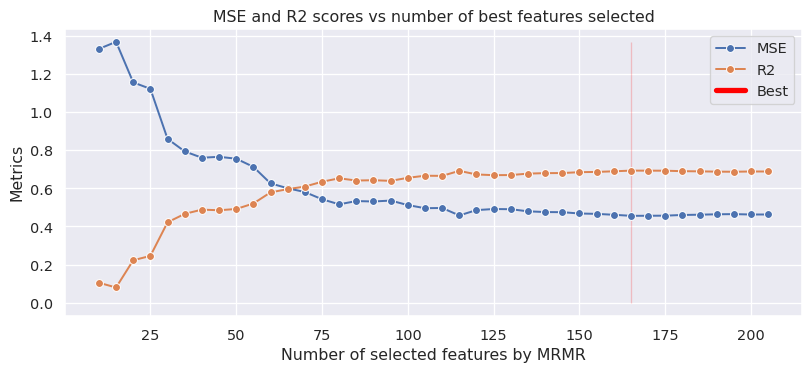

In [22]:
# Added .. made this into a function
# Function to plot regression metrics

def plot_regression_metrics(num_sel_feat, results, fs_name):
    
    mse, r2 = [], []
    for iteration in results:
        mse.append(min([mse[2] for mse in iteration]))
        r2.append(max([r2[0] for r2 in iteration]))

    num_sel_feat = np.arange(10, X_train.shape[1], 5)
        
    # Plot R2 and MSE 
    plt.figure(figsize=(10, 4), dpi = 95)
    sns.set_theme(style="darkgrid")

    sns.lineplot(x = num_sel_feat, y = mse, marker='o', label = 'MSE')
    sns.lineplot(x = num_sel_feat, y = r2, marker='o', label = 'R2')
    
    # Vertical line to indicate best performance
    sns.lineplot([num_sel_feat[np.argmax(r2)], num_sel_feat[np.argmax(r2)]], [0, max(mse)], 
                 color = 'red',linewidth = 4, label = 'Best')
    plt.legend()
    plt.title('MSE and R2 scores vs number of best features selected')
    plt.xlabel('Number of selected features by %s'%fs_name)
    plt.ylabel('Metrics')
    plt.show()
    return mse, r2
    
mse, r2 = plot_regression_metrics(num_sel_feat, results, "MRMR")

In [23]:
# Take selected features by MRMR
selected_features_mrmr = features[np.argmax(r2)]

# features_20 = features[2]
# print(features_20)

Best performance occurs when the number of selected features is **165**. Once again, model that better performs is **SVR**, with the following metrics: **R2: 0.693, MAE: 0.502, MSE: 0.456**. This means there is a **0.05** improvement in the R2 score while using **43** features less.

### Perform Hyper parameter optimisation using randomizedSearchCV() with SVR as its the best performing baseline model

In [189]:
def apply_randsearch(X_train, y_train, X_val, y_val, c,  X_train_norm = 0 , X_val_norm = 0):
    np.random.seed(10)
    
    # Random Forest Classifier parameters
    grid_param_rfc = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'bootstrap': [True, False]}
    
    # SVC parameters
    #grid_param_svc = {'C': [0.1, 1, 10, 100, 1000],
                  #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  #'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                 #}
    
    #SVR parameters
    grid_param_svr = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                      'C' : [1,5,10],
                      'degree' : [3,8],
                      'coef0' : [0.01,10,0.5],
                      'gamma' : ('auto','scale')
                     }
        
    # For Regression
    if c == False:
        # (grid_param_rfr, RandomForestRegressor()),
        rnd_models = []
        for grid in [(grid_param_svr, SVR())]:
            random_model = RandomizedSearchCV(grid[1], param_distributions = grid[0], n_iter = 20, cv = 5, n_jobs = -1)
            rnd_models.append(random_model)

        # Fit the model
        for ind, m in enumerate(rnd_models):
            rnd_models[ind] = m.fit(X_train_norm, y_train)

        # Once models are trained we compute the metrics 
        for i in range(len(rnd_models)):
            print(rnd_models[i].best_params_)
            temp_clf = rnd_models[i].best_estimator_

            #Predict values 
            y_pred = temp_clf.predict(X_val_norm)

            #Compute metrics 
            r2 = metrics.r2_score(y_val, y_pred)
            mae = metrics.mean_absolute_error(y_val, y_pred)
            mse = metrics.mean_squared_error(y_val, y_pred)
            print('r2: %f, mse: %f, mae: %f' %(r2, mse, mae))
        
        return rnd_models, (r2, mae, mse)
    
    # For classification
    else:
        rnd_class_models = []
        for grid in [(grid_param_rfc, RandomForestClassifier())]:
            random_model = RandomizedSearchCV(grid[1], param_distributions = grid[0], n_iter = 20, cv = 5, n_jobs = -1)
            rnd_class_models.append(random_model)

        # Fit the model
        for ind, m in enumerate(rnd_class_models):
            rnd_class_models[ind] = m.fit(X_train_norm, y_train)

        # Once models are trained we compute the metrics 
        for i in range(len(rnd_class_models)):
            print(rnd_class_models[i].best_params_)
            temp_clf = rnd_class_models[i].best_estimator_

            #Predict values 
            y_pred = temp_clf.predict(X_val_norm)

            #Compute metrics 
            mcc = metrics.matthews_corrcoef(y_val, y_pred)
            auc = metrics.roc_auc_score(y_val, y_pred)
            prec = metrics.precision_score(y_val, y_pred)
            recl = metrics.recall_score(y_val, y_pred)
            acc = metrics.accuracy_score(y_val, y_pred)
        
            print('MCC: %0.3f, AUC: %0.3f, Precision: %0.3f, Recall: %0.3f, Accuracy: %0.3f'
              %(mcc, auc, prec, recl, acc))
    
        return rnd_class_models, (mcc, auc, prec, recl, acc)

### Apply hyper parameter optimisation on features retreived from MRMR

In [25]:
rnd_models_mrmr, metrics_rnd_mrmr = apply_randsearch(X_train[selected_features_mrmr]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mrmr]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_mrmr]
                                                        , X_val_norm[selected_features_mrmr])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.748425, mse: 0.374455, mae: 0.447647


### Improving the model: Feature Selection - Relieff 

In [27]:
# ADDED
n_neighbors = 100
models_relief, results_relief, num_sel_feat_relief, features_relief = fs_relieff(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, False, n_neighbors)


=======================Selected features 10/207 =======================
RFR | R2: 0.531, MAE: 0.629, MSE: 0.698
DTR | R2: 0.099, MAE: 0.841, MSE: 1.342
SVR | R2: 0.508, MAE: 0.656, MSE: 0.732
MLPR | R2: 0.476, MAE: 0.655, MSE: 0.781
XGBR | R2: 0.496, MAE: 0.646, MSE: 0.750

=======================Selected features 15/207 =======================
RFR | R2: 0.573, MAE: 0.607, MSE: 0.636
DTR | R2: 0.138, MAE: 0.832, MSE: 1.283
SVR | R2: 0.562, MAE: 0.610, MSE: 0.652
MLPR | R2: 0.482, MAE: 0.656, MSE: 0.771
XGBR | R2: 0.564, MAE: 0.612, MSE: 0.649

=======================Selected features 20/207 =======================
RFR | R2: 0.591, MAE: 0.588, MSE: 0.609
DTR | R2: 0.257, MAE: 0.784, MSE: 1.105
SVR | R2: 0.595, MAE: 0.586, MSE: 0.602
MLPR | R2: 0.501, MAE: 0.642, MSE: 0.743
XGBR | R2: 0.588, MAE: 0.583, MSE: 0.614

=======================Selected features 25/207 =======================
RFR | R2: 0.594, MAE: 0.580, MSE: 0.604
DTR | R2: 0.149, MAE: 0.825, MSE: 1.267
SVR | R2: 0.609, MAE: 

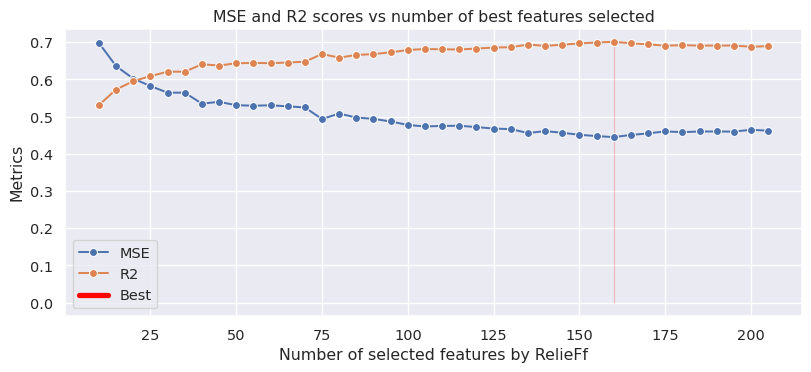

In [28]:
# Added
mse_relieff, r2_relieff = plot_regression_metrics(num_sel_feat_relief, results_relief, "RelieFf")

In [29]:
# Added
# Take selected features by Relieff
selected_features_relieff = features_relief[np.argmax(r2_relieff)]

In [30]:
# Added
rnd_models_relieff, metrics_rnd_relieff = apply_randsearch(X_train[selected_features_relieff]
                                                        , y_train                                                       
                                                        , X_val[selected_features_relieff]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_relieff]
                                                        , X_val_norm[selected_features_relieff])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.753213, mse: 0.367328, mae: 0.446254


### Improving the model: Feature Selection - Mutual_info_regression

#### This method utilizes the mutual information. It calculates mutual information value for each of independent variables with respect to dependent variable, and selects the ones which has most information gain. In other words, it basically measures the dependency of features with the target value. The higher score means more dependent variables.

In [32]:
#Added
# Applying feature selection using mutual_info_regression
models_mir, results_mir, num_sel_feat_mir,features_mir = fs_score_fn(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, False, mutual_info_regression)


=======================Selected features 10/207 =======================
RFR | R2: 0.582, MAE: 0.593, MSE: 0.622
DTR | R2: 0.274, MAE: 0.770, MSE: 1.080
SVR | R2: 0.436, MAE: 0.710, MSE: 0.839
MLPR | R2: 0.354, MAE: 0.721, MSE: 0.961
XGBR | R2: 0.560, MAE: 0.602, MSE: 0.654

=======================Selected features 15/207 =======================
RFR | R2: 0.589, MAE: 0.586, MSE: 0.612
DTR | R2: 0.228, MAE: 0.799, MSE: 1.149
SVR | R2: 0.501, MAE: 0.667, MSE: 0.742
MLPR | R2: 0.320, MAE: 0.732, MSE: 1.013
XGBR | R2: 0.569, MAE: 0.601, MSE: 0.642

=======================Selected features 20/207 =======================
RFR | R2: 0.604, MAE: 0.582, MSE: 0.589
DTR | R2: 0.265, MAE: 0.776, MSE: 1.094
SVR | R2: 0.589, MAE: 0.595, MSE: 0.612
MLPR | R2: 0.487, MAE: 0.634, MSE: 0.763
XGBR | R2: 0.629, MAE: 0.555, MSE: 0.552

=======================Selected features 25/207 =======================
RFR | R2: 0.623, MAE: 0.565, MSE: 0.561
DTR | R2: 0.301, MAE: 0.746, MSE: 1.041
SVR | R2: 0.618, MAE: 

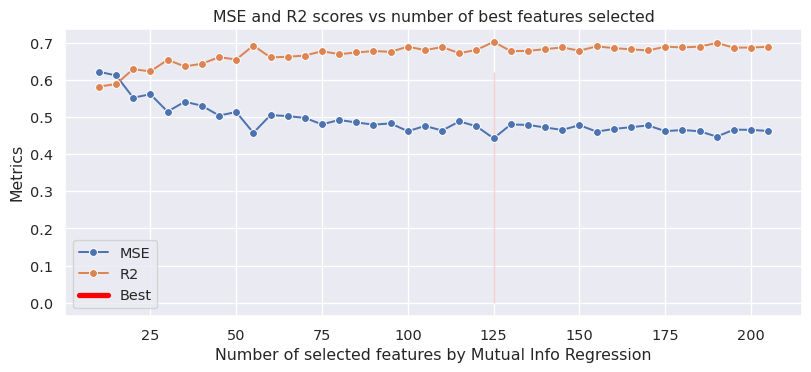

In [33]:
# Added
mse_mir, r2_mir = plot_regression_metrics(num_sel_feat_mir, results_mir, "Mutual Info Regression")

In [34]:
# Added
# Take selected features by mutual_info_regression
selected_features_mir = features_mir[np.argmax(r2_mir)]

In [35]:
# Added
rnd_models_mir, metrics_rnd_mir = apply_randsearch(X_train[selected_features_mir]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mir]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_mir]
                                                        , X_val_norm[selected_features_mir])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.736764, mse: 0.391812, mae: 0.461887


In [268]:
def compare_all_fs_algos(num_sel_feat_mrmr, results_mrmr, num_sel_feat_rf, results_rf, num_sel_feat_mic, results_mic, metric_name):
    plt.figure(figsize=(10, 5), dpi = 95)
    
    if metric_name == "MCC":
        m = 0
    elif metric_name == "AUC":
        m = 1
        
    # Plot for MCC Vs Features selected by MRMR Feature selection
    y_mcc_mrmr = []
    for n in range(len(num_sel_feat_mrmr)):
        # second index is for model -> SVR
        # third index is for metric -> R2
        y_mcc_mrmr.append(results_mrmr[n][2][m])

    # Plot a simple line chart without any feature
    plt.plot(num_sel_feat_mrmr, y_mcc_mrmr, linestyle='dotted', color='red', label="MRMR")


    # Plot for MCC Vs Features selected by Relief Feature selection
    y_mcc_rf = []
    for n in range(len(num_sel_feat_rf)):
        # second index is for model -> SVR
        # third index is for metric -> R2
        y_mcc_rf.append(results_rf[n][2][m])

    # Plot a simple line chart without any feature
    plt.plot(num_sel_feat_rf, y_mcc_rf, color='green', label = "RelieFf")


    # Plot for MCC Vs Features selected by Mutual Info classification Feature selection
    y_mcc_mir = []
    for n in range(len(num_sel_feat_mic)):
        # second index is for model -> SVR
        # third index is for metric -> R2
        y_mcc_mir.append(results_mic[n][2][m])

    # Plot a simple line chart without any feature
    plt.plot(num_sel_feat_mic, y_mcc_mir, linestyle='--', color='blue', label = "Mutual Info Classif")
    plt.title("Performance of Feature selection algorithms Vs Number of features")
    plt.xlabel("Number of features")
    plt.ylabel(metric_name);
    plt.legend()
    plt.show()

In [263]:
# Compare performance of all feature selection algorithms w.r.t R2 metric.. Run this after running relief fs again
#compare_all_fs_algos(num_sel_feat, results, num_sel_feat_relieFf, results_relieFf, num_sel_feat_mir, results_mir)


### Improving the model: Manual data cleaning

#### Pipeline
- Remove **MolLogP** and **BCUT2D** features. 
- Remove **zero variance features**. 
- Remove **high correlated** features.

#### 1 - Remove MolLogP, BCUT2D, and zero variance features. 

In [199]:
#Remove MolLogP, BCUT2D, and features with zero variance
from sklearn.feature_selection import VarianceThreshold

def remove_zero_variance(X_train):
    selector = VarianceThreshold()
    selector.fit(X_train)

    # Selector.get_support() returns a [,num_descriptors] boolean mask. False represents zero variance columns.
    zero_var_cols = [column for column in X_train.columns
                        if column not in X_train.columns[selector.get_support()]]

    print('There are {} columns with zero variance'.format(len(zero_var_cols)))

    # As BCUT features and MolLogP may have counterproductive effects, we proceed to delete them
    zero_var_cols.extend([col for col in df.columns if 'BCUT2D' in col or 'MolLogP' in col])

    # We drop this first set of 11 columns in each set. 
    # for i in [X_train, X_train_norm, X_val, X_val_norm]:
    #     i.drop(zero_var_cols, axis = 1, inplace = True)

    print('Total number of features dropped:', len(zero_var_cols))
    return zero_var_cols

zero_var_cols = remove_zero_variance(X_train)

#### 2 - Remove high correlated features

In [200]:
# We drop the features with a high correlation
def remove_high_corr_features(X_train):
    corr = X_train.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

    # Find features with correlation greater than X
    correlated_features = [col for col in upper.columns if any(upper[col] > 0.95)]

    print('Number of correlated features deleted: {}'.format(len(correlated_features)))
    return correlated_features

correlated_features = remove_high_corr_features(X_train)

In [38]:
# We group all the dropped features
mc_cols = list(set(X_train.columns) - set(correlated_features + zero_var_cols))

print('Total number of remaining descriptors after the data cleaning: {}'.format(len(mc_cols)))

Total number of remaining descriptors after the data cleaning: 159


### Models comparison after data cleaning

RFR | R2: 0.603, MAE: 0.580, MSE: 0.591
DTR | R2: 0.159, MAE: 0.828, MSE: 1.252
SVR | R2: 0.690, MAE: 0.502, MSE: 0.462
MLPR | R2: 0.602, MAE: 0.556, MSE: 0.592
XGBR | R2: 0.636, MAE: 0.538, MSE: 0.542


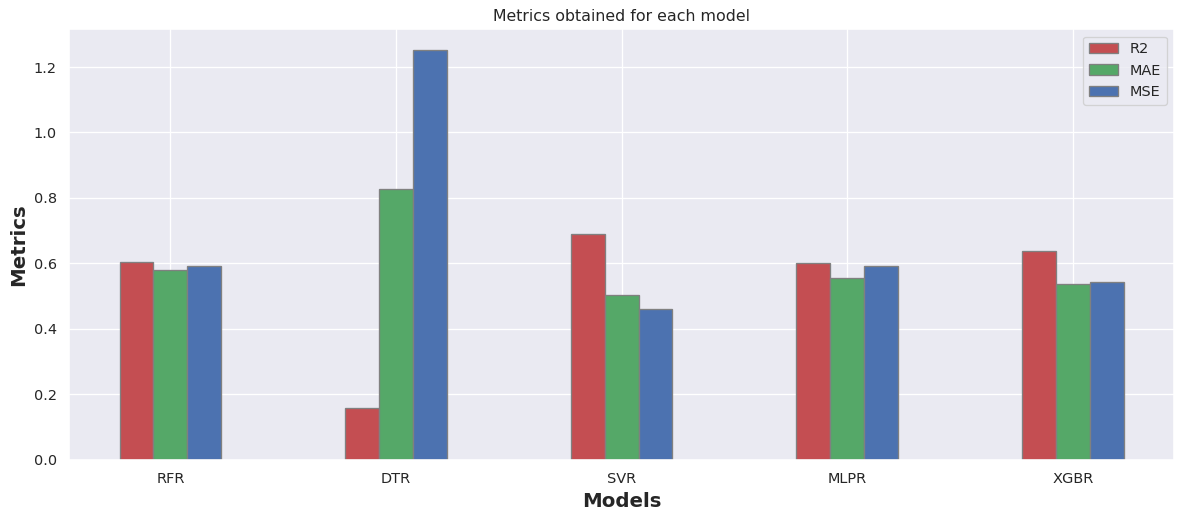

In [39]:
models, results = models_comparison(X_train[mc_cols]
                                    , y_train
                                    , X_val[mc_cols]
                                    , y_val
                                    , False
                                    , True
                                    , False
                                    , X_train_norm[mc_cols]
                                    , X_val_norm[mc_cols])

In [212]:
#We add the best model to our benchmark for a later comparison
#benchmark = add_to_benchmark(benchmark, models, results)

In [41]:
rnd_models_mc, metrics_rnd_mc = apply_randsearch(X_train[mc_cols]
                                                        , y_train                                                       
                                                        , X_val[mc_cols]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[mc_cols]
                                                        , X_val_norm[mc_cols])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.743075, mse: 0.382419, mae: 0.447705


### Exploring alternatives: RandomizedSearchCV() in potential candidates

By making use of RandomizedSearchCV() we could perhaps obtain better metrics in our potential model candidates  SVR and RFR. Function combines randomly the given hyperparameters to adjust the tuning. 

In [42]:
#rnd_models, metrics = apply_randsearch(X_train, X_train_norm, y_train, X_val, False, X_val_norm, y_val)

In [52]:
# Added 
# Once hyper parameter tuning is done apply Relief FS algo on pre-processed/cleaned dataset

models_sel, results_sel, num_sel_feat_sel, features_sel = fs_relieff_selected_features(X_train[mc_cols], y_train, X_val[mc_cols], y_val, X_train_norm[mc_cols], X_val_norm[mc_cols], False, n_neighbors)



=======================Selected features 30/159 =======================
RFR | R2: 0.582, MAE: 0.597, MSE: 0.623
DTR | R2: 0.107, MAE: 0.839, MSE: 1.330
SVR | R2: 0.617, MAE: 0.566, MSE: 0.571
MLPR | R2: 0.481, MAE: 0.644, MSE: 0.773
XGBR | R2: 0.547, MAE: 0.606, MSE: 0.674

=======================Selected features 60/159 =======================
RFR | R2: 0.595, MAE: 0.581, MSE: 0.603
DTR | R2: 0.113, MAE: 0.822, MSE: 1.320
SVR | R2: 0.661, MAE: 0.524, MSE: 0.505
MLPR | R2: 0.587, MAE: 0.581, MSE: 0.615
XGBR | R2: 0.612, MAE: 0.570, MSE: 0.578

=======================Selected features 90/159 =======================
RFR | R2: 0.599, MAE: 0.583, MSE: 0.598
DTR | R2: 0.213, MAE: 0.797, MSE: 1.171
SVR | R2: 0.677, MAE: 0.510, MSE: 0.480
MLPR | R2: 0.614, MAE: 0.554, MSE: 0.574
XGBR | R2: 0.590, MAE: 0.586, MSE: 0.611

=======================Selected features 120/159 =======================
RFR | R2: 0.600, MAE: 0.582, MSE: 0.596
DTR | R2: 0.158, MAE: 0.824, MSE: 1.253
SVR | R2: 0.703, MAE:

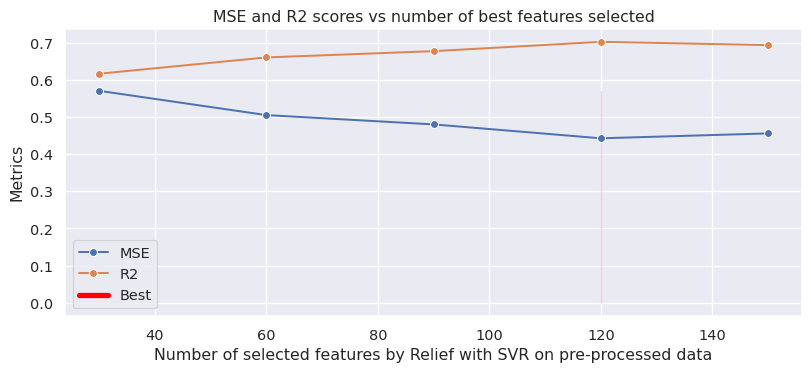

In [57]:
# Added

mse_sel, r2_sel = plot_regression_metrics_reduced_features(X_train[mc_cols], num_sel_feat_sel, results_sel, "Relief with SVR on pre-processed data")


In [77]:
# Save the model 
joblib.dump(rnd_models_mrmr[0], 'optimised_svr_mrmr.pkl')
joblib.dump(rnd_models_relieff[0], 'optimised_svr_relieff.pkl')
joblib.dump(rnd_models_mir[0], 'optimised_svr_mir.pkl')
joblib.dump(rnd_models_mc[0], 'clean.pkl')
joblib.dump(models_sel[0], 'clean_optimised_svr_relief.pkl')


# Loading model
opt_svr_mrmr = joblib.load('optimised_svr_mrmr.pkl')
opt_svr_relieff = joblib.load('optimised_svr_relieff.pkl')
opt_svr_mir = joblib.load('optimised_svr_mir.pkl')
clean = joblib.load('clean.pkl')
clean_opt_svr_relief = joblib.load('clean_optimised_svr_relief.pkl')

### Improving model for fingerprints

#### Optimizing Hyperparameters

##### RandomForestRegressor

In [59]:
#number of trees
n_estimators = [200, 500, 800, 1500, 2500, 5000]
# maw number of levels in a tree
max_depth = [10, 20, 30, 40, 50]
# max number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15]

grid_param = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

rfr = RandomForestRegressor(random_state=1)
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = grid_param, n_iter = 20, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

In [61]:
rfr_random.fit(X_train_fps, y_train)
print(rfr_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 28.2min finished


{'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20}


#### SVM

In [62]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svm = SVR()
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = param_grid, n_iter = 20, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

In [ ]:
svm_random.fit(X_train_fps, y_train)
print(svm_random.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
# score after hyperparameters tuning
def concurrent_models(X_train, y_train, X_valid, y_valid):
    
    models = [
          ('RFR', RandomForestRegressor(n_estimators=500, min_samples_split=20, min_samples_leaf=2,  max_features='auto', max_depth=30)),
          ('SVM', SVR(C=10, gamma=0.001, kernel='rbf'))
        ]
    results = {}
    results['r2'] = []
    results['mse'] = []
    results['mae'] = []
    names = []
    
    for name, model in models:
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_valid)
        
        #R2
        r2 = metrics.r2_score(y_valid, y_pred)
        #MSE
        mse = metrics.mean_squared_error(y_valid, y_pred)
        #MAE
        mae = metrics.mean_absolute_error(y_valid, y_pred)
        
        results['r2'].append(r2)
        results['mse'].append(mse)
        results['mae'].append(r2)
        
        names.append(name)
        
    print(results)
    sns.set(font_scale = 1)
    x = np.arange(len(models))  # the label locations
    width = 0.15  # the width of the bars
    fig, ax = plt.subplots(figsize=(13,6))
    rects1 = ax.bar(x - width, results['r2'], width, label='R2')
    rects2 = ax.bar(x,  results['mse'], width, label='MSE')
    rects3 = ax.bar(x + width,  results['mae'], width, label='MAE')
    
    ax.set_ylabel('Scores', fontweight ='bold', fontsize = 15)
    ax.set_title('Concurrent models scores after hyperparameters tuning', fontweight ='bold', fontsize = 15)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()
    
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()

    plt.show()   

In [ ]:
concurrent_models(X_train_fps, y_train, X_val_fps, y_val)

#### Final model on test set

In [ ]:
svm = SVR(C=10, gamma=0.001, kernel='rbf').fit(X_train_fps, y_train)
y_pred_test = svm.predict(X_test_fps)

print('Mean squared error (MSE): %.2f'
      % metrics.mean_squared_error(y_test, y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % metrics.r2_score(y_test, y_pred_test))

#### Scatter plot of actual vs. predicted Y

In [ ]:
plt.scatter(x=y_test, y=y_pred_test, c="#619CFF", alpha=0.3)

plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

# Ames mutagenicity 
Mutagenicity means the ability of a drug to induce genetic alterations. Drugs that can cause damage to the DNA can result in cell death or other severe adverse effects

In [109]:
data = Tox(name = 'AMES')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_AMES = data.get_split()

Found local copy...
Loading...
Done!


In [110]:
data_overview(df, split_AMES)

Total number of molecules: 7278
Train set: 5094 - 70.0%
Validation set: 728 - 10.0%
Test set: 1456 - 20.0%


,Drug_ID,Drug,Y
0,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1
1,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0
2,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1
3,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1
4,Drug 6,CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O,1


In [ ]:
# Remove fragments of compounds that may contain them
frag_compounds = [comp for comp in df['Drug'] if len(comp.split('.')) > 1]
for ind, c in enumerate(frag_compounds):
    df.loc[df.Drug == frag_compounds[ind], 'Drug'] = frag_compounds[ind].split('.')[0]

print('Number of compounds modified:{}'.format(len(frag_compounds)))

In [111]:
# Duplicates and compounds with less than 5 heavy atoms removal
df = remove_ha_duplicates(df)

Duplicated compounds and with less than 5 heavy atoms have been removed.
New number of compounds: 7140 (-138)


In [112]:
# Standardize the molecules 
df['Drug'] = [standardize_smiles(smi) for smi in df['Drug']]

# Generate a list of lists where each row corresponds to a molecule and each column to a descriptor (transpose step required)
c = [calculator.CalcDescriptors(Chem.MolFromSmiles(smi)) for smi in df['Drug']]

# Convert it into a numpy array and transpose it so the columns represent the descriptors
c = np.asarray(c).transpose()

# Append all the descriptors to the DF
for i, descriptor in enumerate(descList):
    df[descriptor] = c[i]
    
#We move the target (Ames) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

print('Actual shape of the Dataframe:', df.shape)

Actual shape of the Dataframe: (7140, 211)


In [113]:
df.head()

,Drug_ID,Drug,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,Drug 0,O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...,11.663401,-0.396099,11.663401,0.008895,0.181963,342.310,332.230,342.064057,124.0,0.0,0.277383,-0.258290,0.277383,0.258290,0.538462,0.923077,1.307692,16.631769,9.878024,2.243219,-2.142638,2.460575,-1.957799,6.364064,-0.382738,2.267149,1284.790209,17.999271,13.300923,13.300923,12.575387,7.986911,7.986911,6.240968,6.240968,4.982737,4.982737,3.980293,3.980293,-3.80,1.358228e+06,14.535237,4.857510,1.699174,145.443038,0.000000,0.000000,0.000000,0.0,11.374773,0.000000,20.228637,0.000000,0.000000,0.0,36.398202,33.677631,22.905183,20.619071,9.846622,54.464566,0.0,0.000000,0.000000,0.000000,0.000000,80.892307,0.0,0.0,0.000000,11.374773,0.0,0.0,9.846622,0.000000,20.228637,0.000000,60.663671,0.0,43.089794,0.0,86.28,9.846622,20.228637,0.0,11.374773,32.317345,10.772448,12.132734,36.398202,12.132734,0.000000,0.000000,0.0,0.0,22.534604,28.751336,0.017789,0.000000,17.362937,0.000000,0.000000,0.0,0.00,26.0,0.0,6.0,0.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,6.0,2.0,0.0,0.0,0.0,5.0,5.5536,100.9608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,11.824743,-0.170602,11.824743,0.170602,0.269289,301.345,286.225,301.110279,112

In [114]:
# Generate fingerprints dataset and transform into a dataframe
fps = pd.DataFrame([generate_fingerprints(Chem.MolFromSmiles(mol)) for mol in df['Drug']],columns = np.arange(1,1025))

Current shape of the fingerprint dataset: 7140 x 1024


#### Train, validation, and test sets for both Descriptors and fingerprints

In [115]:
X_train, X_train_fps, X_train_all, y_train, X_val, X_val_fps, X_val_all, y_val, X_test, X_test_fps, X_test_all, y_test = train_val_test_split(df, split_AMES, fps)

Data has been split


#### Remove NaNs values

In [116]:
X_train, X_train_fps, X_train_all, y_train, X_val, X_val_fps, X_val_all, y_val, X_test, X_test_all, y_test = remove_nans(X_train, X_val, X_test, y_train, y_val, y_test, X_train_fps, X_val_fps, X_train_all, X_val_all, X_test_all)

Removed the following rows in the train set: Int64Index([231, 3258, 3693], dtype='int64')
Removed the following rows in the val set: Int64Index([5482], dtype='int64')
Removed the following rows in the test set: Int64Index([6439], dtype='int64')


#### Data normalization required in linear models

In [117]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


In [ ]:
X_train_all_norm, X_val_all_norm, X_test_all_norm = normalize_data(X_train_all, X_val_all, X_test_all)

### Check balance of dataset/split

In [ ]:
sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Counts of 0s and 1s in each split')

sns.countplot(x="Y",ax=axes[0, 0], data = df_ames, label = 'Complete dataset')
axes[0, 0].set_title('Full dataset')
sns.barplot(ax=axes[0, 1], x= y_train.value_counts().index, y= y_train.value_counts(), label= 'Training')
axes[0, 1].set_title('Training')

plt.show()

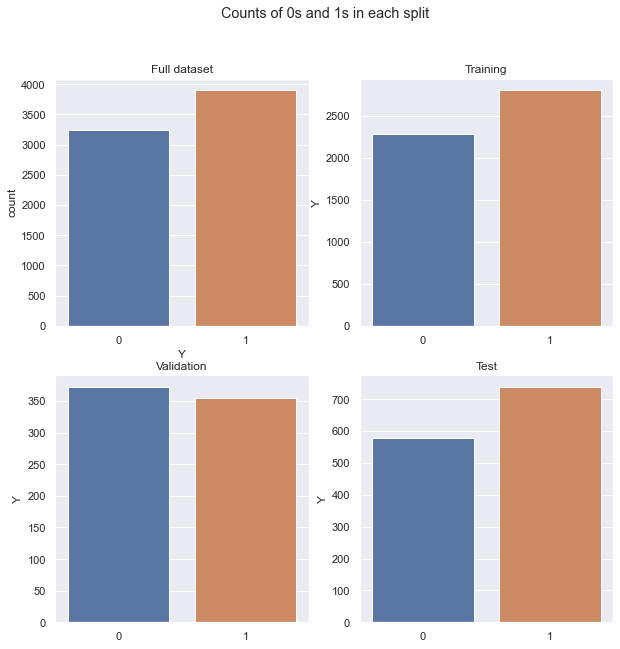

In [118]:
# Added
check_data_balance(df, y_train, y_val, y_test)

## Building our baseline models

### Descriptors

MLPC | MCC: 0.524, AUC: 0.762, Accuracy: 0.749, Precision: 0.772, Recall: 0.762
SVC | MCC: 0.583, AUC: 0.791, Accuracy: 0.771, Precision: 0.814, Recall: 0.791
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.728, Precision: 0.769, Recall: 0.747
[22:14:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.582, AUC: 0.791, Accuracy: 0.777, Precision: 0.803, Recall: 0.791


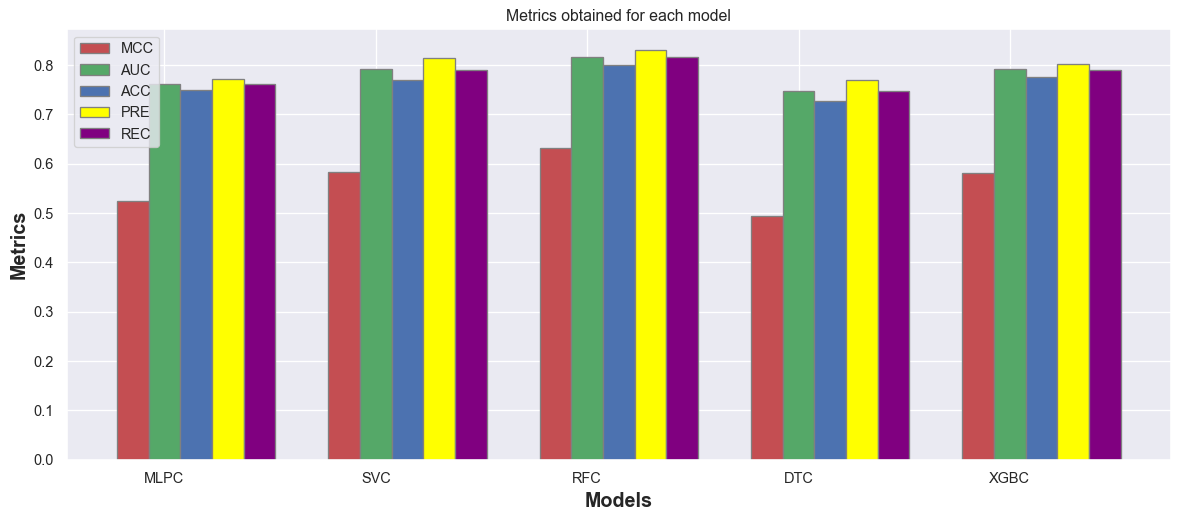

In [119]:
models, results = models_comparison(X_train, y_train, X_val, y_val, True,True, False, X_train_norm, X_val_norm)

In [ ]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, models, results)

### Fingerprints

In [ ]:
models, results = models_comparison(X_train_fps, y_train, X_val_fps, y_val, False, True, True, X_train_fps, X_val_fps)

### Descriptors + Fingerprints

In [ ]:
models, results = models_comparison(X_train_all, y_train, X_val_all, y_val, False, True, False, X_train_all_norm, X_val_all_norm)

## Improving the model 

In [122]:
models, results, num_sel_feat, features = fs_mrmr(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s]


MLPC | MCC: 0.425, AUC: 0.712, Accuracy: 0.711, Precision: 0.693, Recall: 0.713
SVC | MCC: 0.428, AUC: 0.714, Accuracy: 0.705, Precision: 0.713, Recall: 0.714
RFC | MCC: 0.409, AUC: 0.705, Accuracy: 0.689, Precision: 0.718, Recall: 0.704
DTC | MCC: 0.327, AUC: 0.664, Accuracy: 0.646, Precision: 0.687, Recall: 0.663
[22:19:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.451, AUC: 0.725, Accuracy: 0.708, Precision: 0.744, Recall: 0.725


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.43it/s]


MLPC | MCC: 0.464, AUC: 0.732, Accuracy: 0.716, Precision: 0.746, Recall: 0.732
SVC | MCC: 0.461, AUC: 0.730, Accuracy: 0.721, Precision: 0.730, Recall: 0.730
RFC | MCC: 0.489, AUC: 0.744, Accuracy: 0.730, Precision: 0.755, Recall: 0.744
DTC | MCC: 0.339, AUC: 0.669, Accuracy: 0.640, Precision: 0.730, Recall: 0.667
[22:19:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.468, AUC: 0.734, Accuracy: 0.714, Precision: 0.758, Recall: 0.733


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


MLPC | MCC: 0.500, AUC: 0.750, Accuracy: 0.736, Precision: 0.761, Recall: 0.750
SVC | MCC: 0.467, AUC: 0.733, Accuracy: 0.719, Precision: 0.744, Recall: 0.733
RFC | MCC: 0.550, AUC: 0.775, Accuracy: 0.753, Precision: 0.800, Recall: 0.774
DTC | MCC: 0.411, AUC: 0.705, Accuracy: 0.682, Precision: 0.738, Recall: 0.704
[22:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.523, AUC: 0.761, Accuracy: 0.740, Precision: 0.786, Recall: 0.761


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.16it/s]


MLPC | MCC: 0.517, AUC: 0.758, Accuracy: 0.725, Precision: 0.808, Recall: 0.757
SVC | MCC: 0.505, AUC: 0.752, Accuracy: 0.725, Precision: 0.789, Recall: 0.751
RFC | MCC: 0.576, AUC: 0.788, Accuracy: 0.780, Precision: 0.789, Recall: 0.788
DTC | MCC: 0.388, AUC: 0.694, Accuracy: 0.673, Precision: 0.724, Recall: 0.693
[22:20:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.533, AUC: 0.767, Accuracy: 0.747, Precision: 0.789, Recall: 0.766


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.28it/s]


MLPC | MCC: 0.501, AUC: 0.750, Accuracy: 0.727, Precision: 0.780, Recall: 0.750
SVC | MCC: 0.536, AUC: 0.768, Accuracy: 0.747, Precision: 0.792, Recall: 0.768
RFC | MCC: 0.587, AUC: 0.794, Accuracy: 0.786, Precision: 0.794, Recall: 0.794
DTC | MCC: 0.407, AUC: 0.703, Accuracy: 0.683, Precision: 0.730, Recall: 0.703
[22:20:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.546, AUC: 0.773, Accuracy: 0.745, Precision: 0.808, Recall: 0.772


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.53it/s]


MLPC | MCC: 0.536, AUC: 0.766, Accuracy: 0.727, Precision: 0.831, Recall: 0.765
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.745, Precision: 0.792, Recall: 0.766
RFC | MCC: 0.604, AUC: 0.802, Accuracy: 0.787, Precision: 0.814, Recall: 0.802
DTC | MCC: 0.400, AUC: 0.700, Accuracy: 0.674, Precision: 0.741, Recall: 0.699
[22:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.576, AUC: 0.788, Accuracy: 0.762, Precision: 0.820, Recall: 0.787


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.30it/s]


MLPC | MCC: 0.489, AUC: 0.744, Accuracy: 0.729, Precision: 0.758, Recall: 0.744
SVC | MCC: 0.529, AUC: 0.764, Accuracy: 0.738, Precision: 0.800, Recall: 0.763
RFC | MCC: 0.593, AUC: 0.797, Accuracy: 0.785, Precision: 0.803, Recall: 0.796
DTC | MCC: 0.498, AUC: 0.749, Accuracy: 0.728, Precision: 0.775, Recall: 0.748
[22:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.531, AUC: 0.765, Accuracy: 0.732, Precision: 0.814, Recall: 0.763


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:13<00:00,  3.32it/s]


MLPC | MCC: 0.537, AUC: 0.768, Accuracy: 0.742, Precision: 0.803, Recall: 0.768
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.743, Precision: 0.797, Recall: 0.766
RFC | MCC: 0.593, AUC: 0.796, Accuracy: 0.790, Precision: 0.794, Recall: 0.796
DTC | MCC: 0.478, AUC: 0.739, Accuracy: 0.721, Precision: 0.758, Recall: 0.739
[22:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.558, AUC: 0.779, Accuracy: 0.758, Precision: 0.803, Recall: 0.779


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.62it/s]


MLPC | MCC: 0.546, AUC: 0.773, Accuracy: 0.743, Precision: 0.814, Recall: 0.772
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.742, Precision: 0.800, Recall: 0.766
RFC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806
DTC | MCC: 0.460, AUC: 0.730, Accuracy: 0.706, Precision: 0.763, Recall: 0.729
[22:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.563, AUC: 0.781, Accuracy: 0.751, Precision: 0.823, Recall: 0.780


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:15<00:00,  3.44it/s]


MLPC | MCC: 0.558, AUC: 0.779, Accuracy: 0.764, Precision: 0.792, Recall: 0.779
SVC | MCC: 0.524, AUC: 0.762, Accuracy: 0.734, Precision: 0.800, Recall: 0.761
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.801, Precision: 0.837, Recall: 0.818
DTC | MCC: 0.448, AUC: 0.724, Accuracy: 0.706, Precision: 0.744, Recall: 0.724
[22:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.570, AUC: 0.785, Accuracy: 0.758, Precision: 0.820, Recall: 0.784


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.03it/s]


MLPC | MCC: 0.540, AUC: 0.770, Accuracy: 0.744, Precision: 0.803, Recall: 0.769
SVC | MCC: 0.530, AUC: 0.764, Accuracy: 0.735, Precision: 0.806, Recall: 0.763
RFC | MCC: 0.596, AUC: 0.798, Accuracy: 0.784, Precision: 0.808, Recall: 0.798
DTC | MCC: 0.474, AUC: 0.737, Accuracy: 0.712, Precision: 0.772, Recall: 0.736
[22:24:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.578, AUC: 0.789, Accuracy: 0.764, Precision: 0.820, Recall: 0.788


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:20<00:00,  3.24it/s]


MLPC | MCC: 0.537, AUC: 0.769, Accuracy: 0.769, Precision: 0.752, Recall: 0.769
SVC | MCC: 0.522, AUC: 0.760, Accuracy: 0.730, Precision: 0.806, Recall: 0.759
RFC | MCC: 0.648, AUC: 0.824, Accuracy: 0.813, Precision: 0.831, Recall: 0.824
DTC | MCC: 0.527, AUC: 0.763, Accuracy: 0.753, Precision: 0.766, Recall: 0.763
[22:24:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.594, AUC: 0.797, Accuracy: 0.779, Precision: 0.814, Recall: 0.796


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:20<00:00,  3.47it/s]


MLPC | MCC: 0.548, AUC: 0.774, Accuracy: 0.749, Precision: 0.806, Recall: 0.773
SVC | MCC: 0.538, AUC: 0.768, Accuracy: 0.740, Precision: 0.808, Recall: 0.768
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.800, Precision: 0.834, Recall: 0.817
DTC | MCC: 0.453, AUC: 0.727, Accuracy: 0.711, Precision: 0.741, Recall: 0.726
[22:25:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.584, AUC: 0.792, Accuracy: 0.764, Precision: 0.828, Recall: 0.791


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:23<00:00,  3.24it/s]


MLPC | MCC: 0.587, AUC: 0.794, Accuracy: 0.784, Precision: 0.797, Recall: 0.794
SVC | MCC: 0.551, AUC: 0.775, Accuracy: 0.748, Precision: 0.811, Recall: 0.774
RFC | MCC: 0.621, AUC: 0.810, Accuracy: 0.796, Precision: 0.823, Recall: 0.810
DTC | MCC: 0.441, AUC: 0.721, Accuracy: 0.713, Precision: 0.715, Recall: 0.721
[22:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.602, AUC: 0.801, Accuracy: 0.781, Precision: 0.823, Recall: 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.45it/s]


MLPC | MCC: 0.552, AUC: 0.774, Accuracy: 0.735, Precision: 0.837, Recall: 0.773
SVC | MCC: 0.549, AUC: 0.774, Accuracy: 0.744, Precision: 0.817, Recall: 0.773
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.802, Precision: 0.831, Recall: 0.817
DTC | MCC: 0.450, AUC: 0.725, Accuracy: 0.715, Precision: 0.727, Recall: 0.725
[22:26:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.593, AUC: 0.797, Accuracy: 0.784, Precision: 0.806, Recall: 0.796


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:25<00:00,  3.38it/s]


MLPC | MCC: 0.574, AUC: 0.786, Accuracy: 0.745, Precision: 0.848, Recall: 0.784
SVC | MCC: 0.549, AUC: 0.774, Accuracy: 0.744, Precision: 0.817, Recall: 0.773
RFC | MCC: 0.618, AUC: 0.809, Accuracy: 0.798, Precision: 0.814, Recall: 0.809
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.714, Precision: 0.732, Recall: 0.726
[22:27:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.607, AUC: 0.804, Accuracy: 0.788, Precision: 0.817, Recall: 0.803


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:26<00:00,  3.37it/s]


MLPC | MCC: 0.610, AUC: 0.805, Accuracy: 0.792, Precision: 0.814, Recall: 0.805
SVC | MCC: 0.545, AUC: 0.771, Accuracy: 0.739, Precision: 0.820, Recall: 0.770
RFC | MCC: 0.623, AUC: 0.812, Accuracy: 0.798, Precision: 0.823, Recall: 0.812
DTC | MCC: 0.462, AUC: 0.731, Accuracy: 0.714, Precision: 0.746, Recall: 0.730
[22:28:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.602, AUC: 0.801, Accuracy: 0.782, Precision: 0.820, Recall: 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:27<00:00,  3.50it/s]


MLPC | MCC: 0.574, AUC: 0.787, Accuracy: 0.769, Precision: 0.806, Recall: 0.787
SVC | MCC: 0.547, AUC: 0.773, Accuracy: 0.740, Precision: 0.820, Recall: 0.772
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.793, Precision: 0.831, Recall: 0.812
DTC | MCC: 0.447, AUC: 0.724, Accuracy: 0.710, Precision: 0.732, Recall: 0.724
[22:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.597, AUC: 0.798, Accuracy: 0.775, Precision: 0.825, Recall: 0.798


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


MLPC | MCC: 0.602, AUC: 0.801, Accuracy: 0.782, Precision: 0.820, Recall: 0.801
SVC | MCC: 0.539, AUC: 0.769, Accuracy: 0.736, Precision: 0.817, Recall: 0.768
RFC | MCC: 0.621, AUC: 0.811, Accuracy: 0.791, Precision: 0.831, Recall: 0.810
DTC | MCC: 0.476, AUC: 0.738, Accuracy: 0.715, Precision: 0.769, Recall: 0.737
[22:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.578, AUC: 0.789, Accuracy: 0.768, Precision: 0.811, Recall: 0.788


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:30<00:00,  3.49it/s]


MLPC | MCC: 0.574, AUC: 0.787, Accuracy: 0.775, Precision: 0.794, Recall: 0.787
SVC | MCC: 0.563, AUC: 0.781, Accuracy: 0.752, Precision: 0.820, Recall: 0.780
RFC | MCC: 0.643, AUC: 0.822, Accuracy: 0.803, Precision: 0.839, Recall: 0.821
DTC | MCC: 0.507, AUC: 0.753, Accuracy: 0.727, Precision: 0.789, Recall: 0.752
[22:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.613, AUC: 0.806, Accuracy: 0.774, Precision: 0.848, Recall: 0.805


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:30<00:00,  3.61it/s]


MLPC | MCC: 0.557, AUC: 0.778, Accuracy: 0.787, Precision: 0.749, Recall: 0.779
SVC | MCC: 0.554, AUC: 0.777, Accuracy: 0.750, Precision: 0.811, Recall: 0.776
RFC | MCC: 0.647, AUC: 0.823, Accuracy: 0.797, Precision: 0.854, Recall: 0.823
DTC | MCC: 0.479, AUC: 0.739, Accuracy: 0.715, Precision: 0.772, Recall: 0.739
[22:31:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.592, AUC: 0.796, Accuracy: 0.770, Precision: 0.828, Recall: 0.795


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:30<00:00,  3.74it/s]


MLPC | MCC: 0.593, AUC: 0.796, Accuracy: 0.788, Precision: 0.797, Recall: 0.796
SVC | MCC: 0.567, AUC: 0.783, Accuracy: 0.759, Precision: 0.814, Recall: 0.783
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.804, Precision: 0.823, Recall: 0.816
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.727, Precision: 0.772, Recall: 0.747
[22:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.569, AUC: 0.784, Accuracy: 0.766, Precision: 0.803, Recall: 0.784


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:30<00:00,  3.89it/s]


MLPC | MCC: 0.559, AUC: 0.778, Accuracy: 0.744, Precision: 0.828, Recall: 0.777
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.801, Precision: 0.839, Recall: 0.820
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.727, Precision: 0.772, Recall: 0.747
[22:33:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.603, AUC: 0.801, Accuracy: 0.776, Precision: 0.831, Recall: 0.801


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:30<00:00,  4.09it/s]


MLPC | MCC: 0.535, AUC: 0.767, Accuracy: 0.763, Precision: 0.761, Recall: 0.768
SVC | MCC: 0.573, AUC: 0.786, Accuracy: 0.763, Precision: 0.814, Recall: 0.785
RFC | MCC: 0.612, AUC: 0.806, Accuracy: 0.794, Precision: 0.814, Recall: 0.806
DTC | MCC: 0.477, AUC: 0.738, Accuracy: 0.714, Precision: 0.772, Recall: 0.737
[22:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.608, AUC: 0.804, Accuracy: 0.779, Precision: 0.834, Recall: 0.803


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:31<00:00,  4.14it/s]


MLPC | MCC: 0.538, AUC: 0.768, Accuracy: 0.740, Precision: 0.808, Recall: 0.768
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.616, AUC: 0.808, Accuracy: 0.787, Precision: 0.831, Recall: 0.807
DTC | MCC: 0.480, AUC: 0.740, Accuracy: 0.712, Precision: 0.780, Recall: 0.739
[22:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:31<00:00,  4.33it/s]


MLPC | MCC: 0.545, AUC: 0.772, Accuracy: 0.751, Precision: 0.797, Recall: 0.772
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.610, AUC: 0.805, Accuracy: 0.792, Precision: 0.814, Recall: 0.805
DTC | MCC: 0.478, AUC: 0.739, Accuracy: 0.721, Precision: 0.758, Recall: 0.739
[22:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.593, AUC: 0.797, Accuracy: 0.780, Precision: 0.811, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:32<00:00,  4.33it/s]


MLPC | MCC: 0.562, AUC: 0.781, Accuracy: 0.755, Precision: 0.814, Recall: 0.780
SVC | MCC: 0.572, AUC: 0.786, Accuracy: 0.764, Precision: 0.811, Recall: 0.785
RFC | MCC: 0.621, AUC: 0.810, Accuracy: 0.797, Precision: 0.820, Recall: 0.810
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.713, Precision: 0.735, Recall: 0.726
[22:36:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.594, AUC: 0.797, Accuracy: 0.775, Precision: 0.823, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [00:32<00:00,  4.43it/s]


MLPC | MCC: 0.569, AUC: 0.784, Accuracy: 0.766, Precision: 0.803, Recall: 0.784
SVC | MCC: 0.581, AUC: 0.790, Accuracy: 0.767, Precision: 0.817, Recall: 0.790
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.798, Precision: 0.845, Recall: 0.820
DTC | MCC: 0.407, AUC: 0.704, Accuracy: 0.682, Precision: 0.732, Recall: 0.703
[22:37:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.562, AUC: 0.781, Accuracy: 0.755, Precision: 0.814, Recall: 0.780


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:32<00:00,  4.64it/s]


MLPC | MCC: 0.569, AUC: 0.785, Accuracy: 0.765, Precision: 0.806, Recall: 0.784
SVC | MCC: 0.586, AUC: 0.793, Accuracy: 0.771, Precision: 0.817, Recall: 0.792
RFC | MCC: 0.634, AUC: 0.817, Accuracy: 0.812, Precision: 0.814, Recall: 0.817
DTC | MCC: 0.448, AUC: 0.724, Accuracy: 0.704, Precision: 0.749, Recall: 0.724
[22:38:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.596, AUC: 0.798, Accuracy: 0.780, Precision: 0.817, Recall: 0.798


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:33<00:00,  4.66it/s]


MLPC | MCC: 0.615, AUC: 0.808, Accuracy: 0.791, Precision: 0.823, Recall: 0.807
SVC | MCC: 0.580, AUC: 0.790, Accuracy: 0.769, Precision: 0.814, Recall: 0.790
RFC | MCC: 0.629, AUC: 0.815, Accuracy: 0.799, Precision: 0.828, Recall: 0.814
DTC | MCC: 0.447, AUC: 0.724, Accuracy: 0.710, Precision: 0.732, Recall: 0.724
[22:39:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.595, AUC: 0.797, Accuracy: 0.769, Precision: 0.834, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:33<00:00,  4.75it/s]


MLPC | MCC: 0.571, AUC: 0.786, Accuracy: 0.773, Precision: 0.794, Recall: 0.785
SVC | MCC: 0.572, AUC: 0.786, Accuracy: 0.764, Precision: 0.811, Recall: 0.785
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.802, Precision: 0.831, Recall: 0.817
DTC | MCC: 0.467, AUC: 0.733, Accuracy: 0.718, Precision: 0.746, Recall: 0.733
[22:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.799, Accuracy: 0.785, Precision: 0.811, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:33<00:00,  4.92it/s]


MLPC | MCC: 0.593, AUC: 0.796, Accuracy: 0.768, Precision: 0.831, Recall: 0.795
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.646, AUC: 0.823, Accuracy: 0.804, Precision: 0.842, Recall: 0.823
DTC | MCC: 0.414, AUC: 0.707, Accuracy: 0.693, Precision: 0.718, Recall: 0.707
[22:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.799, Accuracy: 0.786, Precision: 0.808, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [00:34<00:00,  4.89it/s]


MLPC | MCC: 0.569, AUC: 0.785, Accuracy: 0.765, Precision: 0.806, Recall: 0.784
SVC | MCC: 0.570, AUC: 0.785, Accuracy: 0.761, Precision: 0.814, Recall: 0.784
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.797, Precision: 0.842, Recall: 0.818
DTC | MCC: 0.457, AUC: 0.728, Accuracy: 0.707, Precision: 0.755, Recall: 0.728
[22:41:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.800, Accuracy: 0.783, Precision: 0.814, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:34<00:00,  5.10it/s]


MLPC | MCC: 0.580, AUC: 0.790, Accuracy: 0.772, Precision: 0.808, Recall: 0.790
SVC | MCC: 0.573, AUC: 0.786, Accuracy: 0.763, Precision: 0.814, Recall: 0.785
RFC | MCC: 0.649, AUC: 0.824, Accuracy: 0.806, Precision: 0.842, Recall: 0.824
DTC | MCC: 0.470, AUC: 0.735, Accuracy: 0.720, Precision: 0.746, Recall: 0.735
[22:42:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.604, AUC: 0.802, Accuracy: 0.787, Precision: 0.814, Recall: 0.802


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:34<00:00,  5.16it/s]


MLPC | MCC: 0.571, AUC: 0.785, Accuracy: 0.779, Precision: 0.783, Recall: 0.785
SVC | MCC: 0.567, AUC: 0.783, Accuracy: 0.761, Precision: 0.808, Recall: 0.783
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.803, Precision: 0.825, Recall: 0.816
DTC | MCC: 0.451, AUC: 0.725, Accuracy: 0.708, Precision: 0.744, Recall: 0.725
[22:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:33<00:00,  5.46it/s]


MLPC | MCC: 0.579, AUC: 0.789, Accuracy: 0.761, Precision: 0.825, Recall: 0.788
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.634, AUC: 0.817, Accuracy: 0.803, Precision: 0.828, Recall: 0.817
DTC | MCC: 0.461, AUC: 0.730, Accuracy: 0.721, Precision: 0.730, Recall: 0.730
[22:44:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.608, AUC: 0.804, Accuracy: 0.782, Precision: 0.828, Recall: 0.803


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:34<00:00,  5.56it/s]


MLPC | MCC: 0.571, AUC: 0.786, Accuracy: 0.770, Precision: 0.800, Recall: 0.785
SVC | MCC: 0.581, AUC: 0.790, Accuracy: 0.767, Precision: 0.817, Recall: 0.790
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.793, Precision: 0.831, Recall: 0.812
DTC | MCC: 0.475, AUC: 0.737, Accuracy: 0.724, Precision: 0.746, Recall: 0.737
[22:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.616, AUC: 0.808, Accuracy: 0.785, Precision: 0.834, Recall: 0.807


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:34<00:00,  5.64it/s]


MLPC | MCC: 0.570, AUC: 0.785, Accuracy: 0.758, Precision: 0.820, Recall: 0.784
SVC | MCC: 0.583, AUC: 0.792, Accuracy: 0.769, Precision: 0.817, Recall: 0.791
RFC | MCC: 0.640, AUC: 0.820, Accuracy: 0.806, Precision: 0.831, Recall: 0.820
DTC | MCC: 0.451, AUC: 0.725, Accuracy: 0.706, Precision: 0.749, Recall: 0.725
[22:46:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.60it/s]


MLPC | MCC: 0.588, AUC: 0.794, Accuracy: 0.776, Precision: 0.811, Recall: 0.794
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.767, Precision: 0.808, Recall: 0.787
RFC | MCC: 0.618, AUC: 0.809, Accuracy: 0.795, Precision: 0.820, Recall: 0.809
DTC | MCC: 0.497, AUC: 0.748, Accuracy: 0.718, Precision: 0.794, Recall: 0.747
[22:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.618, AUC: 0.809, Accuracy: 0.795, Precision: 0.820, Recall: 0.809


100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [00:40<00:00,  4.97it/s]


MLPC | MCC: 0.598, AUC: 0.799, Accuracy: 0.798, Precision: 0.789, Recall: 0.799
SVC | MCC: 0.583, AUC: 0.791, Accuracy: 0.771, Precision: 0.814, Recall: 0.791
RFC | MCC: 0.652, AUC: 0.826, Accuracy: 0.805, Precision: 0.848, Recall: 0.825
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.698, Precision: 0.769, Recall: 0.725
[22:48:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.618, AUC: 0.809, Accuracy: 0.790, Precision: 0.828, Recall: 0.809


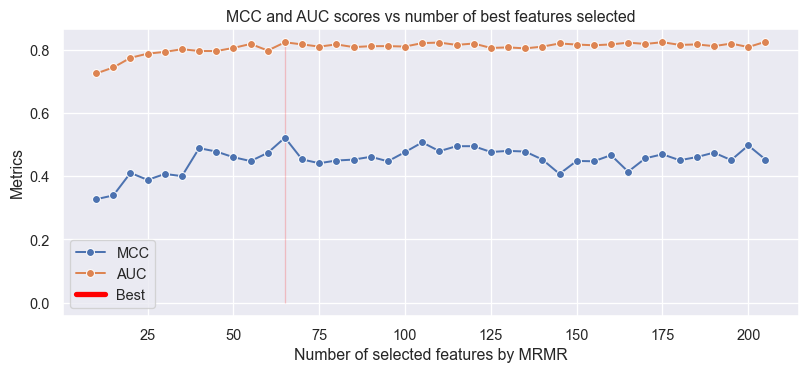

In [138]:
mcc, auc = plot_classification_metrics(results, X_train)

Best performance occurs when the number of selected features is **65**. In this case, the model that better performs is **RFC**, with the following metrics: **MCC: 0.648, AUC: 0.824, Accuracy: 0.813, Precision: 0.831, Recall: 0.824**. This means there is a **0.16** improvement in the MCC score while using **143** less features.

### Added: Classification for Ames dataset

### Train, validation, and test sets for both Descriptors 


In [127]:
df_ames=df

In [128]:
X_train, X_train_desc, y_train, X_val, X_val_desc, y_val, X_test, X_test_desc, y_test = train_val_test_split(df_ames, split_AMES, df)

Data has been split


### Remove NaNs

In [129]:
X_train, X_train_desc, y_train, X_val, X_val_desc, X_test, y_test = remove_nans(X_train, X_val, X_test, y_train, y_val, y_test, X_train_desc, X_val_desc)

Removed the following rows in the train set: Int64Index([231, 3258, 3693], dtype='int64')
Removed the following rows in the val set: Int64Index([5482], dtype='int64')
Removed the following rows in the test set: Int64Index([6439], dtype='int64')


### Data normalization is required in linear models

In [130]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


### Building Baseline models for descriptors

MLPC | MCC: 0.524, AUC: 0.762, Accuracy: 0.749, Precision: 0.772, Recall: 0.762
SVC | MCC: 0.583, AUC: 0.791, Accuracy: 0.771, Precision: 0.814, Recall: 0.791
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.728, Precision: 0.769, Recall: 0.747
[22:52:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.582, AUC: 0.791, Accuracy: 0.777, Precision: 0.803, Recall: 0.791


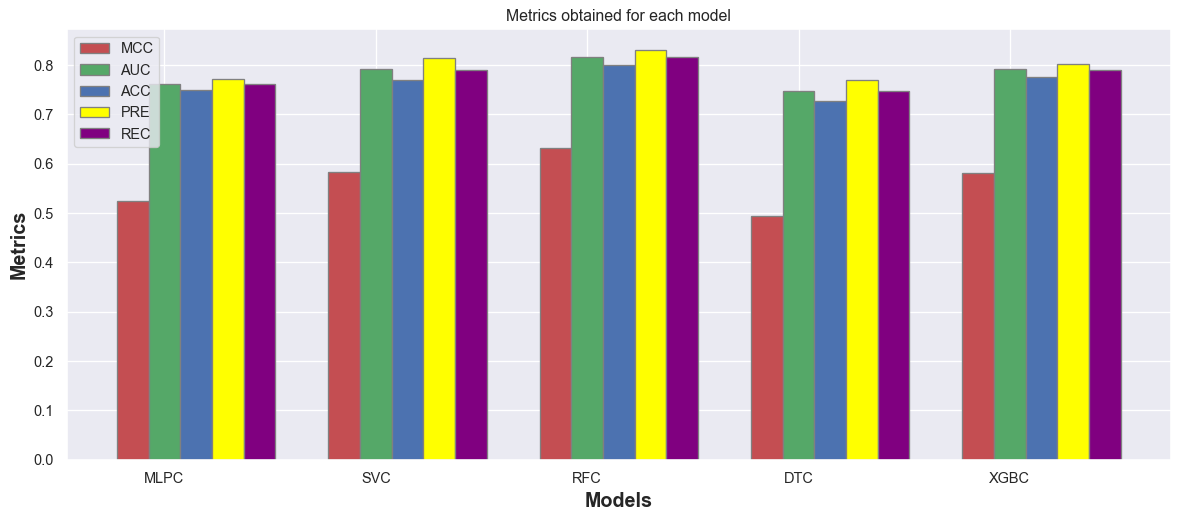

In [132]:
models_desc, results_desc = models_comparison(X_train, y_train, X_val, y_val, True,True, False, X_train_norm, X_val_norm)

In [133]:
models_mrmr, results_mrmr, num_sel_feat_mrmr, features_mrmr = fs_mrmr(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s]


MLPC | MCC: 0.425, AUC: 0.712, Accuracy: 0.711, Precision: 0.693, Recall: 0.713
SVC | MCC: 0.428, AUC: 0.714, Accuracy: 0.705, Precision: 0.713, Recall: 0.714
RFC | MCC: 0.409, AUC: 0.705, Accuracy: 0.689, Precision: 0.718, Recall: 0.704
DTC | MCC: 0.327, AUC: 0.664, Accuracy: 0.646, Precision: 0.687, Recall: 0.663
[22:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.451, AUC: 0.725, Accuracy: 0.708, Precision: 0.744, Recall: 0.725


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.95it/s]


MLPC | MCC: 0.464, AUC: 0.732, Accuracy: 0.716, Precision: 0.746, Recall: 0.732
SVC | MCC: 0.461, AUC: 0.730, Accuracy: 0.721, Precision: 0.730, Recall: 0.730
RFC | MCC: 0.489, AUC: 0.744, Accuracy: 0.730, Precision: 0.755, Recall: 0.744
DTC | MCC: 0.339, AUC: 0.669, Accuracy: 0.640, Precision: 0.730, Recall: 0.667
[22:52:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.468, AUC: 0.734, Accuracy: 0.714, Precision: 0.758, Recall: 0.733


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.96it/s]


MLPC | MCC: 0.500, AUC: 0.750, Accuracy: 0.736, Precision: 0.761, Recall: 0.750
SVC | MCC: 0.467, AUC: 0.733, Accuracy: 0.719, Precision: 0.744, Recall: 0.733
RFC | MCC: 0.550, AUC: 0.775, Accuracy: 0.753, Precision: 0.800, Recall: 0.774
DTC | MCC: 0.411, AUC: 0.705, Accuracy: 0.682, Precision: 0.738, Recall: 0.704
[22:53:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.523, AUC: 0.761, Accuracy: 0.740, Precision: 0.786, Recall: 0.761


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.90it/s]


MLPC | MCC: 0.517, AUC: 0.758, Accuracy: 0.725, Precision: 0.808, Recall: 0.757
SVC | MCC: 0.505, AUC: 0.752, Accuracy: 0.725, Precision: 0.789, Recall: 0.751
RFC | MCC: 0.576, AUC: 0.788, Accuracy: 0.780, Precision: 0.789, Recall: 0.788
DTC | MCC: 0.388, AUC: 0.694, Accuracy: 0.673, Precision: 0.724, Recall: 0.693
[22:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.533, AUC: 0.767, Accuracy: 0.747, Precision: 0.789, Recall: 0.766


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]


MLPC | MCC: 0.501, AUC: 0.750, Accuracy: 0.727, Precision: 0.780, Recall: 0.750
SVC | MCC: 0.536, AUC: 0.768, Accuracy: 0.747, Precision: 0.792, Recall: 0.768
RFC | MCC: 0.587, AUC: 0.794, Accuracy: 0.786, Precision: 0.794, Recall: 0.794
DTC | MCC: 0.407, AUC: 0.703, Accuracy: 0.683, Precision: 0.730, Recall: 0.703
[22:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.546, AUC: 0.773, Accuracy: 0.745, Precision: 0.808, Recall: 0.772


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:11<00:00,  3.14it/s]


MLPC | MCC: 0.536, AUC: 0.766, Accuracy: 0.727, Precision: 0.831, Recall: 0.765
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.745, Precision: 0.792, Recall: 0.766
RFC | MCC: 0.604, AUC: 0.802, Accuracy: 0.787, Precision: 0.814, Recall: 0.802
DTC | MCC: 0.400, AUC: 0.700, Accuracy: 0.674, Precision: 0.741, Recall: 0.699
[22:55:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.576, AUC: 0.788, Accuracy: 0.762, Precision: 0.820, Recall: 0.787


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.38it/s]


MLPC | MCC: 0.489, AUC: 0.744, Accuracy: 0.729, Precision: 0.758, Recall: 0.744
SVC | MCC: 0.529, AUC: 0.764, Accuracy: 0.738, Precision: 0.800, Recall: 0.763
RFC | MCC: 0.593, AUC: 0.797, Accuracy: 0.785, Precision: 0.803, Recall: 0.796
DTC | MCC: 0.498, AUC: 0.749, Accuracy: 0.728, Precision: 0.775, Recall: 0.748
[22:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.531, AUC: 0.765, Accuracy: 0.732, Precision: 0.814, Recall: 0.763


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:13<00:00,  3.40it/s]


MLPC | MCC: 0.537, AUC: 0.768, Accuracy: 0.742, Precision: 0.803, Recall: 0.768
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.743, Precision: 0.797, Recall: 0.766
RFC | MCC: 0.593, AUC: 0.796, Accuracy: 0.790, Precision: 0.794, Recall: 0.796
DTC | MCC: 0.478, AUC: 0.739, Accuracy: 0.721, Precision: 0.758, Recall: 0.739
[22:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.558, AUC: 0.779, Accuracy: 0.758, Precision: 0.803, Recall: 0.779


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.45it/s]


MLPC | MCC: 0.546, AUC: 0.773, Accuracy: 0.743, Precision: 0.814, Recall: 0.772
SVC | MCC: 0.534, AUC: 0.767, Accuracy: 0.742, Precision: 0.800, Recall: 0.766
RFC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806
DTC | MCC: 0.460, AUC: 0.730, Accuracy: 0.706, Precision: 0.763, Recall: 0.729
[22:56:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.563, AUC: 0.781, Accuracy: 0.751, Precision: 0.823, Recall: 0.780


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.03it/s]


MLPC | MCC: 0.558, AUC: 0.779, Accuracy: 0.764, Precision: 0.792, Recall: 0.779
SVC | MCC: 0.524, AUC: 0.762, Accuracy: 0.734, Precision: 0.800, Recall: 0.761
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.801, Precision: 0.837, Recall: 0.818
DTC | MCC: 0.448, AUC: 0.724, Accuracy: 0.706, Precision: 0.744, Recall: 0.724
[22:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.570, AUC: 0.785, Accuracy: 0.758, Precision: 0.820, Recall: 0.784


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.33it/s]


MLPC | MCC: 0.540, AUC: 0.770, Accuracy: 0.744, Precision: 0.803, Recall: 0.769
SVC | MCC: 0.530, AUC: 0.764, Accuracy: 0.735, Precision: 0.806, Recall: 0.763
RFC | MCC: 0.596, AUC: 0.798, Accuracy: 0.784, Precision: 0.808, Recall: 0.798
DTC | MCC: 0.474, AUC: 0.737, Accuracy: 0.712, Precision: 0.772, Recall: 0.736
[22:57:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.578, AUC: 0.789, Accuracy: 0.764, Precision: 0.820, Recall: 0.788


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:20<00:00,  3.21it/s]


MLPC | MCC: 0.537, AUC: 0.769, Accuracy: 0.769, Precision: 0.752, Recall: 0.769
SVC | MCC: 0.522, AUC: 0.760, Accuracy: 0.730, Precision: 0.806, Recall: 0.759
RFC | MCC: 0.648, AUC: 0.824, Accuracy: 0.813, Precision: 0.831, Recall: 0.824
DTC | MCC: 0.527, AUC: 0.763, Accuracy: 0.753, Precision: 0.766, Recall: 0.763
[22:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.594, AUC: 0.797, Accuracy: 0.779, Precision: 0.814, Recall: 0.796


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:20<00:00,  3.37it/s]


MLPC | MCC: 0.548, AUC: 0.774, Accuracy: 0.749, Precision: 0.806, Recall: 0.773
SVC | MCC: 0.538, AUC: 0.768, Accuracy: 0.740, Precision: 0.808, Recall: 0.768
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.800, Precision: 0.834, Recall: 0.817
DTC | MCC: 0.453, AUC: 0.727, Accuracy: 0.711, Precision: 0.741, Recall: 0.726
[22:58:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.584, AUC: 0.792, Accuracy: 0.764, Precision: 0.828, Recall: 0.791


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.32it/s]


MLPC | MCC: 0.587, AUC: 0.794, Accuracy: 0.784, Precision: 0.797, Recall: 0.794
SVC | MCC: 0.551, AUC: 0.775, Accuracy: 0.748, Precision: 0.811, Recall: 0.774
RFC | MCC: 0.621, AUC: 0.810, Accuracy: 0.796, Precision: 0.823, Recall: 0.810
DTC | MCC: 0.441, AUC: 0.721, Accuracy: 0.713, Precision: 0.715, Recall: 0.721
[22:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.602, AUC: 0.801, Accuracy: 0.781, Precision: 0.823, Recall: 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.43it/s]


MLPC | MCC: 0.552, AUC: 0.774, Accuracy: 0.735, Precision: 0.837, Recall: 0.773
SVC | MCC: 0.549, AUC: 0.774, Accuracy: 0.744, Precision: 0.817, Recall: 0.773
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.802, Precision: 0.831, Recall: 0.817
DTC | MCC: 0.450, AUC: 0.725, Accuracy: 0.715, Precision: 0.727, Recall: 0.725
[23:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.593, AUC: 0.797, Accuracy: 0.784, Precision: 0.806, Recall: 0.796


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:26<00:00,  3.19it/s]


MLPC | MCC: 0.574, AUC: 0.786, Accuracy: 0.745, Precision: 0.848, Recall: 0.784
SVC | MCC: 0.549, AUC: 0.774, Accuracy: 0.744, Precision: 0.817, Recall: 0.773
RFC | MCC: 0.618, AUC: 0.809, Accuracy: 0.798, Precision: 0.814, Recall: 0.809
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.714, Precision: 0.732, Recall: 0.726
[23:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.607, AUC: 0.804, Accuracy: 0.788, Precision: 0.817, Recall: 0.803


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.53it/s]


MLPC | MCC: 0.610, AUC: 0.805, Accuracy: 0.792, Precision: 0.814, Recall: 0.805
SVC | MCC: 0.545, AUC: 0.771, Accuracy: 0.739, Precision: 0.820, Recall: 0.770
RFC | MCC: 0.623, AUC: 0.812, Accuracy: 0.798, Precision: 0.823, Recall: 0.812
DTC | MCC: 0.462, AUC: 0.731, Accuracy: 0.714, Precision: 0.746, Recall: 0.730
[23:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.602, AUC: 0.801, Accuracy: 0.782, Precision: 0.820, Recall: 0.801


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:27<00:00,  3.44it/s]


MLPC | MCC: 0.574, AUC: 0.787, Accuracy: 0.769, Precision: 0.806, Recall: 0.787
SVC | MCC: 0.547, AUC: 0.773, Accuracy: 0.740, Precision: 0.820, Recall: 0.772
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.793, Precision: 0.831, Recall: 0.812
DTC | MCC: 0.447, AUC: 0.724, Accuracy: 0.710, Precision: 0.732, Recall: 0.724
[23:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.597, AUC: 0.798, Accuracy: 0.775, Precision: 0.825, Recall: 0.798


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


MLPC | MCC: 0.602, AUC: 0.801, Accuracy: 0.782, Precision: 0.820, Recall: 0.801
SVC | MCC: 0.539, AUC: 0.769, Accuracy: 0.736, Precision: 0.817, Recall: 0.768
RFC | MCC: 0.621, AUC: 0.811, Accuracy: 0.791, Precision: 0.831, Recall: 0.810
DTC | MCC: 0.476, AUC: 0.738, Accuracy: 0.715, Precision: 0.769, Recall: 0.737
[23:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.578, AUC: 0.789, Accuracy: 0.768, Precision: 0.811, Recall: 0.788


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:32<00:00,  3.24it/s]


MLPC | MCC: 0.574, AUC: 0.787, Accuracy: 0.775, Precision: 0.794, Recall: 0.787
SVC | MCC: 0.563, AUC: 0.781, Accuracy: 0.752, Precision: 0.820, Recall: 0.780
RFC | MCC: 0.643, AUC: 0.822, Accuracy: 0.803, Precision: 0.839, Recall: 0.821
DTC | MCC: 0.507, AUC: 0.753, Accuracy: 0.727, Precision: 0.789, Recall: 0.752
[23:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.613, AUC: 0.806, Accuracy: 0.774, Precision: 0.848, Recall: 0.805


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:33<00:00,  3.33it/s]


MLPC | MCC: 0.557, AUC: 0.778, Accuracy: 0.787, Precision: 0.749, Recall: 0.779
SVC | MCC: 0.554, AUC: 0.777, Accuracy: 0.750, Precision: 0.811, Recall: 0.776
RFC | MCC: 0.647, AUC: 0.823, Accuracy: 0.797, Precision: 0.854, Recall: 0.823
DTC | MCC: 0.479, AUC: 0.739, Accuracy: 0.715, Precision: 0.772, Recall: 0.739
[23:05:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.592, AUC: 0.796, Accuracy: 0.770, Precision: 0.828, Recall: 0.795


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:30<00:00,  3.75it/s]


MLPC | MCC: 0.593, AUC: 0.796, Accuracy: 0.788, Precision: 0.797, Recall: 0.796
SVC | MCC: 0.567, AUC: 0.783, Accuracy: 0.759, Precision: 0.814, Recall: 0.783
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.804, Precision: 0.823, Recall: 0.816
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.727, Precision: 0.772, Recall: 0.747
[23:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.569, AUC: 0.784, Accuracy: 0.766, Precision: 0.803, Recall: 0.784


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:32<00:00,  3.68it/s]


MLPC | MCC: 0.559, AUC: 0.778, Accuracy: 0.744, Precision: 0.828, Recall: 0.777
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.801, Precision: 0.839, Recall: 0.820
DTC | MCC: 0.495, AUC: 0.747, Accuracy: 0.727, Precision: 0.772, Recall: 0.747
[23:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.603, AUC: 0.801, Accuracy: 0.776, Precision: 0.831, Recall: 0.801


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:33<00:00,  3.79it/s]


MLPC | MCC: 0.535, AUC: 0.767, Accuracy: 0.763, Precision: 0.761, Recall: 0.768
SVC | MCC: 0.573, AUC: 0.786, Accuracy: 0.763, Precision: 0.814, Recall: 0.785
RFC | MCC: 0.612, AUC: 0.806, Accuracy: 0.794, Precision: 0.814, Recall: 0.806
DTC | MCC: 0.477, AUC: 0.738, Accuracy: 0.714, Precision: 0.772, Recall: 0.737
[23:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.608, AUC: 0.804, Accuracy: 0.779, Precision: 0.834, Recall: 0.803


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:34<00:00,  3.74it/s]


MLPC | MCC: 0.538, AUC: 0.768, Accuracy: 0.740, Precision: 0.808, Recall: 0.768
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.616, AUC: 0.808, Accuracy: 0.787, Precision: 0.831, Recall: 0.807
DTC | MCC: 0.480, AUC: 0.740, Accuracy: 0.712, Precision: 0.780, Recall: 0.739
[23:08:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:32<00:00,  4.11it/s]


MLPC | MCC: 0.545, AUC: 0.772, Accuracy: 0.751, Precision: 0.797, Recall: 0.772
SVC | MCC: 0.564, AUC: 0.782, Accuracy: 0.758, Precision: 0.811, Recall: 0.781
RFC | MCC: 0.610, AUC: 0.805, Accuracy: 0.792, Precision: 0.814, Recall: 0.805
DTC | MCC: 0.478, AUC: 0.739, Accuracy: 0.721, Precision: 0.758, Recall: 0.739
[23:09:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.593, AUC: 0.797, Accuracy: 0.780, Precision: 0.811, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:34<00:00,  4.03it/s]


MLPC | MCC: 0.562, AUC: 0.781, Accuracy: 0.755, Precision: 0.814, Recall: 0.780
SVC | MCC: 0.572, AUC: 0.786, Accuracy: 0.764, Precision: 0.811, Recall: 0.785
RFC | MCC: 0.621, AUC: 0.810, Accuracy: 0.797, Precision: 0.820, Recall: 0.810
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.713, Precision: 0.735, Recall: 0.726
[23:10:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.594, AUC: 0.797, Accuracy: 0.775, Precision: 0.823, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [00:31<00:00,  4.60it/s]


MLPC | MCC: 0.569, AUC: 0.784, Accuracy: 0.766, Precision: 0.803, Recall: 0.784
SVC | MCC: 0.581, AUC: 0.790, Accuracy: 0.767, Precision: 0.817, Recall: 0.790
RFC | MCC: 0.641, AUC: 0.820, Accuracy: 0.798, Precision: 0.845, Recall: 0.820
DTC | MCC: 0.407, AUC: 0.704, Accuracy: 0.682, Precision: 0.732, Recall: 0.703
[23:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.562, AUC: 0.781, Accuracy: 0.755, Precision: 0.814, Recall: 0.780


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:32<00:00,  4.62it/s]


MLPC | MCC: 0.569, AUC: 0.785, Accuracy: 0.765, Precision: 0.806, Recall: 0.784
SVC | MCC: 0.586, AUC: 0.793, Accuracy: 0.771, Precision: 0.817, Recall: 0.792
RFC | MCC: 0.634, AUC: 0.817, Accuracy: 0.812, Precision: 0.814, Recall: 0.817
DTC | MCC: 0.448, AUC: 0.724, Accuracy: 0.704, Precision: 0.749, Recall: 0.724
[23:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.596, AUC: 0.798, Accuracy: 0.780, Precision: 0.817, Recall: 0.798


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:34<00:00,  4.46it/s]


MLPC | MCC: 0.615, AUC: 0.808, Accuracy: 0.791, Precision: 0.823, Recall: 0.807
SVC | MCC: 0.580, AUC: 0.790, Accuracy: 0.769, Precision: 0.814, Recall: 0.790
RFC | MCC: 0.629, AUC: 0.815, Accuracy: 0.799, Precision: 0.828, Recall: 0.814
DTC | MCC: 0.447, AUC: 0.724, Accuracy: 0.710, Precision: 0.732, Recall: 0.724
[23:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.595, AUC: 0.797, Accuracy: 0.769, Precision: 0.834, Recall: 0.796


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:33<00:00,  4.80it/s]


MLPC | MCC: 0.571, AUC: 0.786, Accuracy: 0.773, Precision: 0.794, Recall: 0.785
SVC | MCC: 0.572, AUC: 0.786, Accuracy: 0.764, Precision: 0.811, Recall: 0.785
RFC | MCC: 0.635, AUC: 0.817, Accuracy: 0.802, Precision: 0.831, Recall: 0.817
DTC | MCC: 0.467, AUC: 0.733, Accuracy: 0.718, Precision: 0.746, Recall: 0.733
[23:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.799, Accuracy: 0.785, Precision: 0.811, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:34<00:00,  4.76it/s]


MLPC | MCC: 0.593, AUC: 0.796, Accuracy: 0.768, Precision: 0.831, Recall: 0.795
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.646, AUC: 0.823, Accuracy: 0.804, Precision: 0.842, Recall: 0.823
DTC | MCC: 0.414, AUC: 0.707, Accuracy: 0.693, Precision: 0.718, Recall: 0.707
[23:15:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.799, Accuracy: 0.786, Precision: 0.808, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [00:34<00:00,  4.94it/s]


MLPC | MCC: 0.569, AUC: 0.785, Accuracy: 0.765, Precision: 0.806, Recall: 0.784
SVC | MCC: 0.570, AUC: 0.785, Accuracy: 0.761, Precision: 0.814, Recall: 0.784
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.797, Precision: 0.842, Recall: 0.818
DTC | MCC: 0.457, AUC: 0.728, Accuracy: 0.707, Precision: 0.755, Recall: 0.728
[23:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.599, AUC: 0.800, Accuracy: 0.783, Precision: 0.814, Recall: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:35<00:00,  4.87it/s]


MLPC | MCC: 0.580, AUC: 0.790, Accuracy: 0.772, Precision: 0.808, Recall: 0.790
SVC | MCC: 0.573, AUC: 0.786, Accuracy: 0.763, Precision: 0.814, Recall: 0.785
RFC | MCC: 0.649, AUC: 0.824, Accuracy: 0.806, Precision: 0.842, Recall: 0.824
DTC | MCC: 0.470, AUC: 0.735, Accuracy: 0.720, Precision: 0.746, Recall: 0.735
[23:16:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.604, AUC: 0.802, Accuracy: 0.787, Precision: 0.814, Recall: 0.802


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:34<00:00,  5.17it/s]


MLPC | MCC: 0.571, AUC: 0.785, Accuracy: 0.779, Precision: 0.783, Recall: 0.785
SVC | MCC: 0.567, AUC: 0.783, Accuracy: 0.761, Precision: 0.808, Recall: 0.783
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.803, Precision: 0.825, Recall: 0.816
DTC | MCC: 0.451, AUC: 0.725, Accuracy: 0.708, Precision: 0.744, Recall: 0.725
[23:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.612, AUC: 0.806, Accuracy: 0.792, Precision: 0.817, Recall: 0.806


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:39<00:00,  4.63it/s]


MLPC | MCC: 0.579, AUC: 0.789, Accuracy: 0.761, Precision: 0.825, Recall: 0.788
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.634, AUC: 0.817, Accuracy: 0.803, Precision: 0.828, Recall: 0.817
DTC | MCC: 0.461, AUC: 0.730, Accuracy: 0.721, Precision: 0.730, Recall: 0.730
[23:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.608, AUC: 0.804, Accuracy: 0.782, Precision: 0.828, Recall: 0.803


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:33<00:00,  5.61it/s]


MLPC | MCC: 0.571, AUC: 0.786, Accuracy: 0.770, Precision: 0.800, Recall: 0.785
SVC | MCC: 0.581, AUC: 0.790, Accuracy: 0.767, Precision: 0.817, Recall: 0.790
RFC | MCC: 0.624, AUC: 0.812, Accuracy: 0.793, Precision: 0.831, Recall: 0.812
DTC | MCC: 0.475, AUC: 0.737, Accuracy: 0.724, Precision: 0.746, Recall: 0.737
[23:20:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.616, AUC: 0.808, Accuracy: 0.785, Precision: 0.834, Recall: 0.807


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:33<00:00,  5.74it/s]


MLPC | MCC: 0.570, AUC: 0.785, Accuracy: 0.758, Precision: 0.820, Recall: 0.784
SVC | MCC: 0.583, AUC: 0.792, Accuracy: 0.769, Precision: 0.817, Recall: 0.791
RFC | MCC: 0.640, AUC: 0.820, Accuracy: 0.806, Precision: 0.831, Recall: 0.820
DTC | MCC: 0.451, AUC: 0.725, Accuracy: 0.706, Precision: 0.749, Recall: 0.725
[23:21:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.632, AUC: 0.816, Accuracy: 0.799, Precision: 0.831, Recall: 0.816


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.49it/s]


MLPC | MCC: 0.588, AUC: 0.794, Accuracy: 0.776, Precision: 0.811, Recall: 0.794
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.767, Precision: 0.808, Recall: 0.787
RFC | MCC: 0.618, AUC: 0.809, Accuracy: 0.795, Precision: 0.820, Recall: 0.809
DTC | MCC: 0.497, AUC: 0.748, Accuracy: 0.718, Precision: 0.794, Recall: 0.747
[23:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.618, AUC: 0.809, Accuracy: 0.795, Precision: 0.820, Recall: 0.809


100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [00:41<00:00,  4.87it/s]


MLPC | MCC: 0.598, AUC: 0.799, Accuracy: 0.798, Precision: 0.789, Recall: 0.799
SVC | MCC: 0.583, AUC: 0.791, Accuracy: 0.771, Precision: 0.814, Recall: 0.791
RFC | MCC: 0.652, AUC: 0.826, Accuracy: 0.805, Precision: 0.848, Recall: 0.825
DTC | MCC: 0.453, AUC: 0.726, Accuracy: 0.698, Precision: 0.769, Recall: 0.725
[23:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.618, AUC: 0.809, Accuracy: 0.790, Precision: 0.828, Recall: 0.809


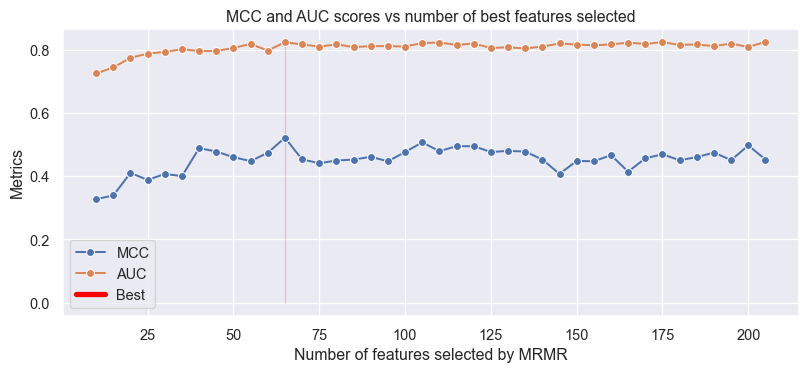

In [192]:
mcc_mrmr, auc_mrmr = plot_classification_metrics(results_mrmr, X_train, "MRMR")

In [178]:
# Added
# Take selected features by MRMR
selected_features_mr = features_mrmr[np.argmax(mcc_mrmr)]


In [188]:
# Added
rnd_models_mr, metrics_rnd_mr = apply_randsearch(X_train[selected_features_mr]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mr]
                                                        , y_val
                                                        , True
                                                        , X_train_norm[selected_features_mr]
                                                        , X_val_norm[selected_features_mr])

{'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
MCC: 0.596, AUC: 0.798, Precision: 0.784, Recall: 0.808, Accuracy: 0.798
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
MCC: 0.646, AUC: 0.823, Precision: 0.804, Recall: 0.842, Accuracy: 0.823


### Applying Relief feature selection

In [148]:
# ADDED
# Applying Relief feature selection

def fs_relieff(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, c, n_neighbors):
    
    num_sel_feat = np.arange(10, X_train.shape[1], 5)
    
    m,r,f = [], [], []
    
    for k in list(num_sel_feat):
        print("\n=======================Selected features %0.0f/%0.0f ======================="%(k,X_train.shape[1]))
        # Applying relieff feature selection on train, validation and normalized datasets
        fs = ReliefF(n_features_to_select=k, n_neighbors=n_neighbors)
        
        fs.fit_transform(X_train.to_numpy(), y_train.to_numpy())
        pos = pd.DataFrame(fs.feature_importances_.reshape(-1,1)).sort_values(by=0, ascending=False).head(k).index.tolist()
        selected_features = list(X_train.columns[pos])

        f.append(selected_features) 
        
        # Get metrics based on selected features
        models, results = models_comparison(X_train[selected_features], y_train, X_val[selected_features], y_val,
                            c, False, False, X_train_norm[selected_features], X_val_norm[selected_features])
                
        m.append(models)
        r.append(results)
        
    return m,r,num_sel_feat,f 

In [149]:
# Added
n_neighbors = 100
models_rf, results_rf, num_sel_feat_rf, features_rf = fs_relieff(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, True, n_neighbors)



=======================Selected features 10/207 =======================
MLPC | MCC: 0.474, AUC: 0.736, Accuracy: 0.703, Precision: 0.792, Recall: 0.735
SVC | MCC: 0.416, AUC: 0.706, Accuracy: 0.669, Precision: 0.780, Recall: 0.704
RFC | MCC: 0.585, AUC: 0.793, Accuracy: 0.776, Precision: 0.808, Recall: 0.792
DTC | MCC: 0.439, AUC: 0.719, Accuracy: 0.692, Precision: 0.761, Recall: 0.718
[00:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.579, AUC: 0.789, Accuracy: 0.760, Precision: 0.828, Recall: 0.788

=======================Selected features 15/207 =======================
MLPC | MCC: 0.487, AUC: 0.743, Accuracy: 0.721, Precision: 0.772, Recall: 0.743
SVC | MCC: 0.455, AUC: 0.726, Accuracy: 0.693, Precision: 0.783, Re

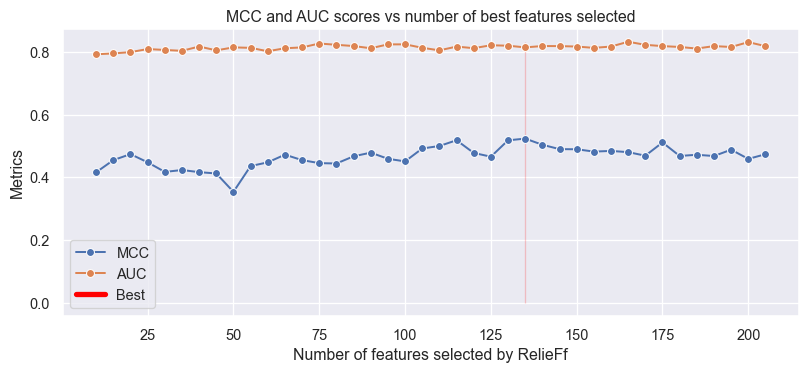

In [193]:
# Added
mcc_rf, auc_rf = plot_classification_metrics(results_rf, X_train, "RelieFf")

In [194]:
# Added
# Take selected features by RelieFf
selected_features_rf = features_rf[np.argmax(mcc_rf)]

In [195]:
# Added
# Hyperparameter optimisation post relief feature selection
rnd_models_rf, metrics_rnd_rf = apply_randsearch(X_train[selected_features_rf]
                                                        , y_train                                                       
                                                        , X_val[selected_features_rf]
                                                        , y_val
                                                        , True
                                                        , X_train_norm[selected_features_rf]
                                                        , X_val_norm[selected_features_rf])

{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
MCC: 0.641, AUC: 0.820, Precision: 0.798, Recall: 0.845, Accuracy: 0.820


In [159]:
# ADDED
# Applying various feature selection algorithm supplied by the score_func
def fs_score_fn(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, c, score_fn):
    
    num_sel_feat = np.arange(10, X_train.shape[1], 5)
    
    m,r,f = [], [], []
    
    for k in list(num_sel_feat):
        print("\n=======================Selected features %0.0f/%0.0f ======================="%(k,X_train.shape[1]))
        
        # Applying feature selection algorithm supplied by the score_func on train, validation and normalized datasets
        fs = SelectKBest(score_func=score_fn, k=k)         
        fs.fit(X_train, y_train)
                
        # Retreive selected feature names
        selected_features=X_train.columns[fs.get_support()]
        
        f.append(selected_features) 
        
        # Get metrics based on selected features
        models, results = models_comparison(X_train[selected_features], y_train, X_val[selected_features], y_val,
                            c, False, False, X_train_norm[selected_features], X_val_norm[selected_features])
        
        m.append(models)
        r.append(results)
         
    return m,r,num_sel_feat,f 

In [162]:
#Added
# Applying feature selection using scoring function as mutual_info_classification
models_mic, results_mic, num_sel_feat_mic, features_mic = fs_score_fn(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, True, mutual_info_classif)


=======================Selected features 10/207 =======================
MLPC | MCC: 0.532, AUC: 0.766, Accuracy: 0.738, Precision: 0.803, Recall: 0.765
SVC | MCC: 0.419, AUC: 0.709, Accuracy: 0.686, Precision: 0.744, Recall: 0.708
RFC | MCC: 0.566, AUC: 0.783, Accuracy: 0.768, Precision: 0.794, Recall: 0.783
DTC | MCC: 0.487, AUC: 0.743, Accuracy: 0.723, Precision: 0.766, Recall: 0.743
[14:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.592, AUC: 0.796, Accuracy: 0.771, Precision: 0.825, Recall: 0.795

=======================Selected features 15/207 =======================
MLPC | MCC: 0.489, AUC: 0.742, Accuracy: 0.700, Precision: 0.820, Recall: 0.740
SVC | MCC: 0.463, AUC: 0.730, Accuracy: 0.697, Precision: 0.789, Re

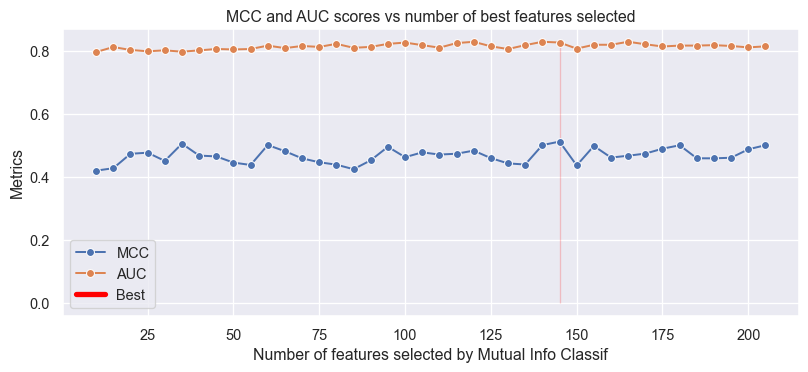

In [173]:
# Added
mcc_mic, auc_mic = plot_classification_metrics(results_mic, X_train, "Mutual Info Classif")

In [196]:
# Added
# Take selected features by mutual info classification
selected_features_mic = features_mic[np.argmax(mcc_mic)]

In [197]:
# Added
# Hyperparameter optimisation post mutual info classification feature selection
rnd_models_mic, metrics_rnd_mic = apply_randsearch(X_train[selected_features_mic]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mic]
                                                        , y_val
                                                        , True
                                                        , X_train_norm[selected_features_mic]
                                                        , X_val_norm[selected_features_mic])

{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
MCC: 0.643, AUC: 0.822, Precision: 0.802, Recall: 0.842, Accuracy: 0.821


### 1 - Remove MolLogP, BCUT2D, and zero variance features.
### 2 - Remove Highly correlated features

In [201]:
zero_var_cols = remove_zero_variance(X_train)

There are 5 columns with zero variance
Total number of features dropped: 14


In [202]:
correlated_features = remove_high_corr_features(X_train)

Number of correlated features deleted: 30


In [203]:
# We group all the dropped features
mc_cols = list(set(X_train.columns) - set(correlated_features + zero_var_cols))

print('Total number of remaining descriptors after the data cleaning: {}'.format(len(mc_cols)))

Total number of remaining descriptors after the data cleaning: 163


### Models comparison after data cleaning

MLPC | MCC: 0.597, AUC: 0.798, Accuracy: 0.774, Precision: 0.828, Recall: 0.798
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.765, Precision: 0.814, Recall: 0.787
RFC | MCC: 0.638, AUC: 0.819, Accuracy: 0.799, Precision: 0.839, Recall: 0.818
DTC | MCC: 0.478, AUC: 0.738, Accuracy: 0.710, Precision: 0.780, Recall: 0.737
[01:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBC | MCC: 0.583, AUC: 0.792, Accuracy: 0.769, Precision: 0.817, Recall: 0.791


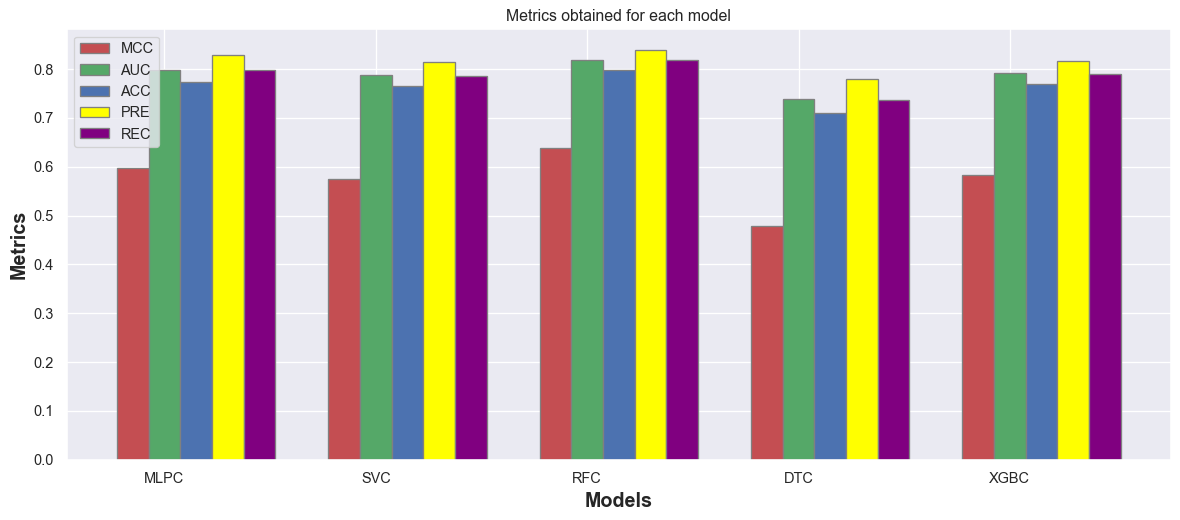

In [204]:
models_c, results_c = models_comparison(X_train[mc_cols]
                                    , y_train
                                    , X_val[mc_cols]
                                    , y_val
                                    , True
                                    , True
                                    , False
                                    , X_train_norm[mc_cols]
                                    , X_val_norm[mc_cols])

In [209]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, models_c, results_c)

In [210]:
rnd_models_mc_c, metrics_rnd_mc_c = apply_randsearch(X_train[mc_cols]
                                                        , y_train                                                       
                                                        , X_val[mc_cols]
                                                        , y_val
                                                        , True
                                                        , X_train_norm[mc_cols]
                                                        , X_val_norm[mc_cols])

{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
MCC: 0.646, AUC: 0.823, Precision: 0.804, Recall: 0.842, Accuracy: 0.823


## Compare performance of all feature selection algorithms w.r.t MCC metric

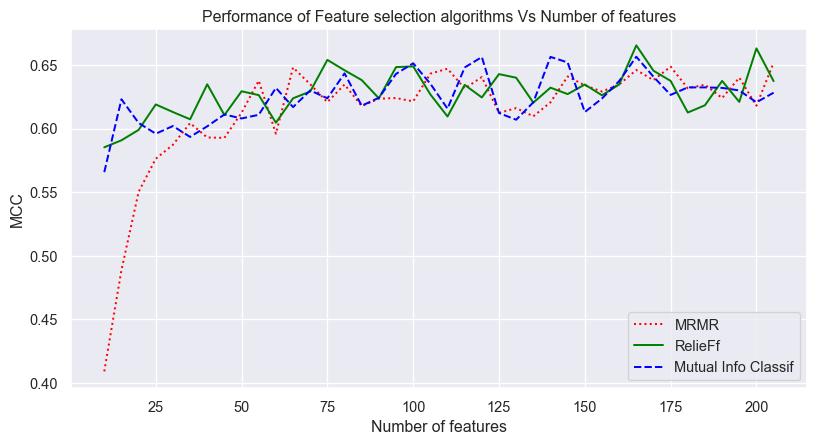

In [269]:
compare_all_fs_algos(num_sel_feat_mrmr, results_mrmr, num_sel_feat_rf, results_rf, num_sel_feat_mic, results_mic, "MCC")

## Compare performance of all feature selection algorithms w.r.t AUC metric

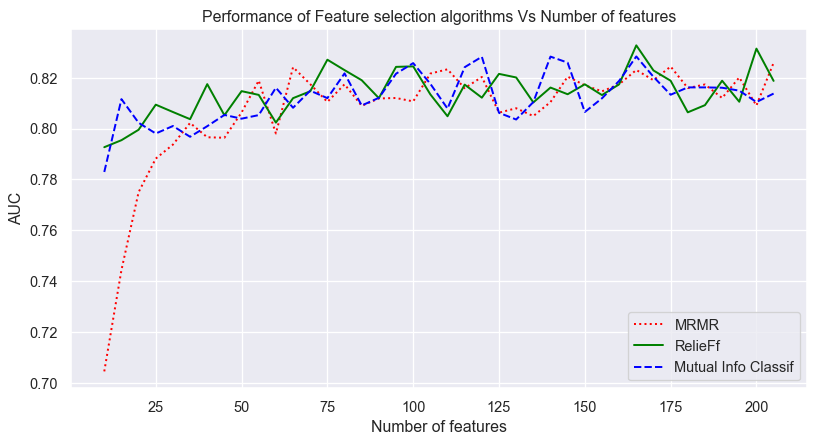

In [270]:
compare_all_fs_algos(num_sel_feat_mrmr, results_mrmr, num_sel_feat_rf, results_rf, num_sel_feat_mic, results_mic, "AUC")

### Improving model for fingerprints